# 1. Анализ предоставленных данных (EDA)

## 1.1 Импорт всех необходимых библиотек и чтение данных

In [151]:
import warnings
warnings.filterwarnings('ignore')

In [152]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
import pyarrow.parquet as pa
import pyspark as ps
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, col, first
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from statsmodels.tsa.seasonal import seasonal_decompose
import joblib

In [153]:
pd.set_option('display.max_rows', None)

In [154]:
pd.options.display.float_format ='{:,.3f}'.format

In [155]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [156]:
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

In [157]:
spark

In [158]:
df = spark.read.parquet('train.parquet')

## 1.2 Анализ полученных данных

In [159]:
df.show()

+-----+--------------------+--------------------+-----+
|   id|               dates|              values|label|
+-----+--------------------+--------------------+-----+
|19114|[2016-01-01, 2016...|[-1.86, 0.79, 1.4...|  0.0|
|22769|[2016-05-01, 2016...|[-1.04, -3.48, 0....|  1.0|
|76935|[2017-03-01, 2017...|[0.28, 0.63, 0.06...|  0.0|
|66297|[2016-01-01, 2016...|[-0.33, 0.58, 1.1...|  0.0|
| 2191|[2016-01-01, 2016...|[1.31, 0.5, -0.54...|  0.0|
|59504|[2016-03-01, 2016...|[0.08, 0.88, 1.46...|  0.0|
|49554|[2016-04-01, 2016...|[1.05, -0.28, 1.0...|  0.0|
|58344|[2016-12-01, 2017...|[-0.36, -0.45, -0...|  0.0|
|87449|[2016-01-01, 2016...|[2.92, 4.11, 3.39...|  1.0|
|43415|[2016-02-01, 2016...|[-0.86, -0.05, -0...|  1.0|
|76676|[2016-01-01, 2016...|[2.24, 0.46, 1.41...|  0.0|
| 4321|[2016-01-01, 2016...|[1.1, 1.73, 2.04,...|  0.0|
|17921|[2016-01-01, 2016...|[1.06, 1.04, 0.62...|  0.0|
|60176|[2016-01-01, 2016...|[1.41, -0.62, -1....|  0.0|
|61864|[2016-01-01, 2016...|[0.24, 0.37, 0.97...

In [160]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[id: bigint, dates: array<date>, values: array<double>, label: double]>

In [161]:
df.pandas_api().isna().mean()

id       0.000
dates    0.000
values   0.000
label    0.000
dtype: float64

Проанализировав структуру данных, были разработаны два варианта обработки DataFrame для дальнейшей передачи этих данных моделям МО:
 - временые ряды дат и значений можно преобразовать в соответствующие значения вертикально: для каждого id будет будет n строк в зависимости от длин массивов в столбцах;
 - выбрать из всех дат все уникальные значения преобразовать в столбцы и соответствующие значения из values сделать значением для этого столбца.

## 1.3 Преобразование данных

Для последующего анализа необходимо преобразовать исходные данные в pandas.DataFrame. Рассмотрим сначала первый вариант преобразований.

In [162]:
df_zip = df.withColumn("zip_date_val", arrays_zip("dates", "values"))

In [163]:
df_exp = df_zip.withColumn("explod_date_val", explode("zip_date_val"))

In [164]:
df_new = df_exp.select(
    col("id"),
    col("explod_date_val.dates").alias("date"),
    col("explod_date_val.values").alias("value"),
    col("label")
)

In [165]:
df_new.printSchema

<bound method DataFrame.printSchema of DataFrame[id: bigint, date: date, value: double, label: double]>

In [166]:
df_new.show()

+-----+----------+-----+-----+
|   id|      date|value|label|
+-----+----------+-----+-----+
|19114|2016-01-01|-1.86|  0.0|
|19114|2016-02-01| 0.79|  0.0|
|19114|2016-03-01|  1.4|  0.0|
|19114|2016-04-01| 0.15|  0.0|
|19114|2016-05-01|  0.0|  0.0|
|19114|2016-06-01|-1.24|  0.0|
|19114|2016-07-01|-1.46|  0.0|
|19114|2016-08-01| 3.49|  0.0|
|19114|2016-09-01|  1.2|  0.0|
|19114|2016-10-01| 1.93|  0.0|
|19114|2016-11-01| 0.46|  0.0|
|19114|2016-12-01| 2.42|  0.0|
|19114|2017-01-01|-4.84|  0.0|
|19114|2017-02-01| 1.37|  0.0|
|19114|2017-03-01|-0.24|  0.0|
|19114|2017-04-01|-0.54|  0.0|
|19114|2017-05-01|-0.43|  0.0|
|19114|2017-06-01| 1.18|  0.0|
|19114|2017-07-01| 0.03|  0.0|
|19114|2017-08-01|-0.76|  0.0|
+-----+----------+-----+-----+
only showing top 20 rows



In [167]:
df_new_pd = df_new.toPandas()

In [168]:
df_new_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5155412 entries, 0 to 5155411
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   date    object 
 2   value   float64
 3   label   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 157.3+ MB


In [169]:
df_new_pd.head()

id        date  value  label
0  19114  2016-01-01 -1.860  0.000
1  19114  2016-02-01  0.790  0.000
2  19114  2016-03-01  1.400  0.000
3  19114  2016-04-01  0.150  0.000
4  19114  2016-05-01  0.000  0.000

In [170]:
df_new_pd.isna().sum()

id          0
date        0
value    4582
label       0
dtype: int64

In [171]:
df_new_pd = df_new_pd.dropna()

In [172]:
df_new_pd.isna().sum()

id       0
date     0
value    0
label    0
dtype: int64

## 1.4 Анализ временных рядов

Как и было описано, в DataFrame у нас присутствуют временные ряды. Поэтому сначала сгруппируем данные по id и дате, а затем отобразим графики этих временных рядов.

In [173]:
df_n = df_new_pd.sort_values(by=['id', 'date'])

In [174]:
grouped = df_n.groupby('id')

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 0')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

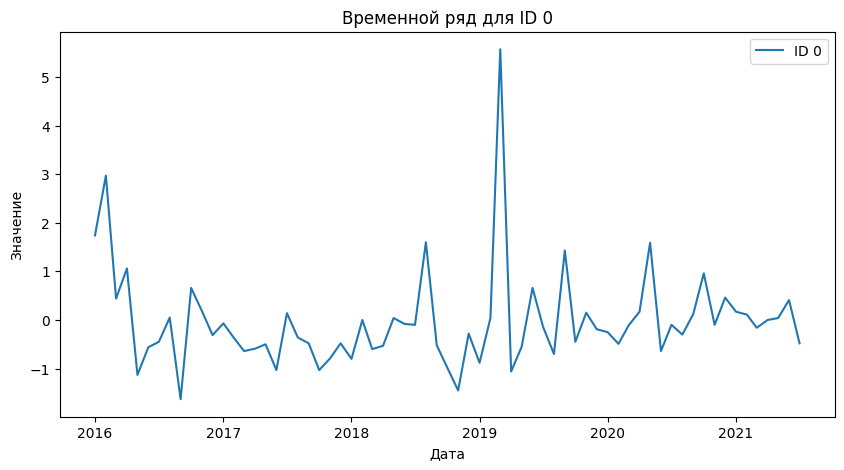

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 1')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

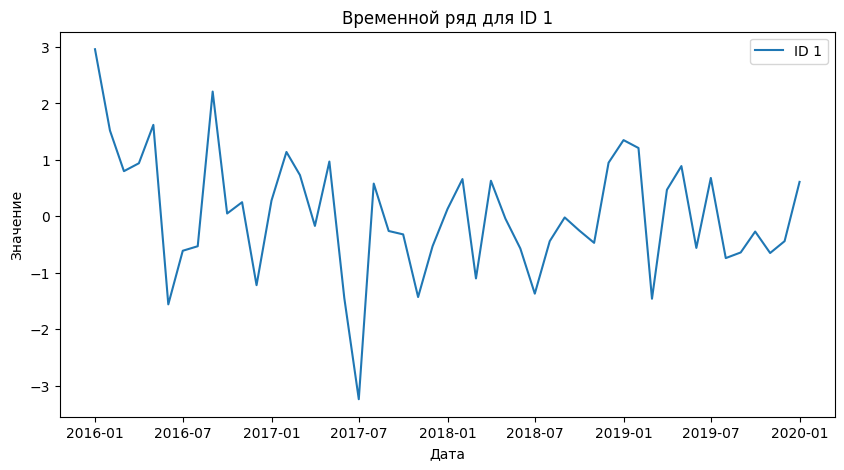

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 3')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

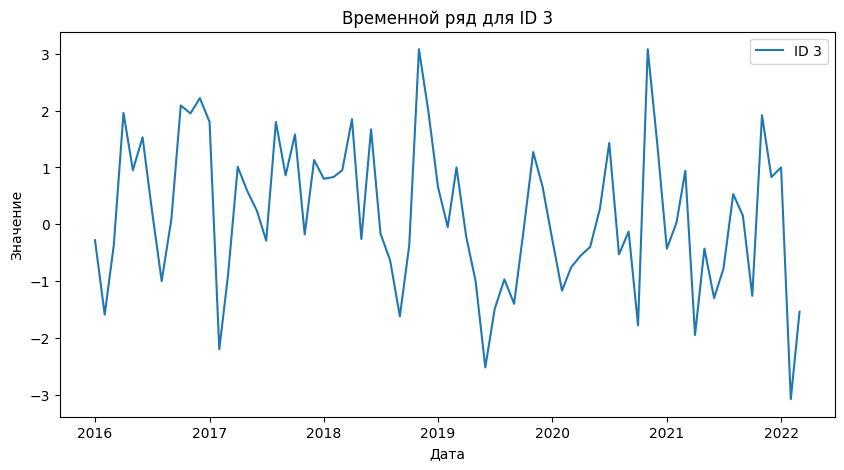

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 4')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

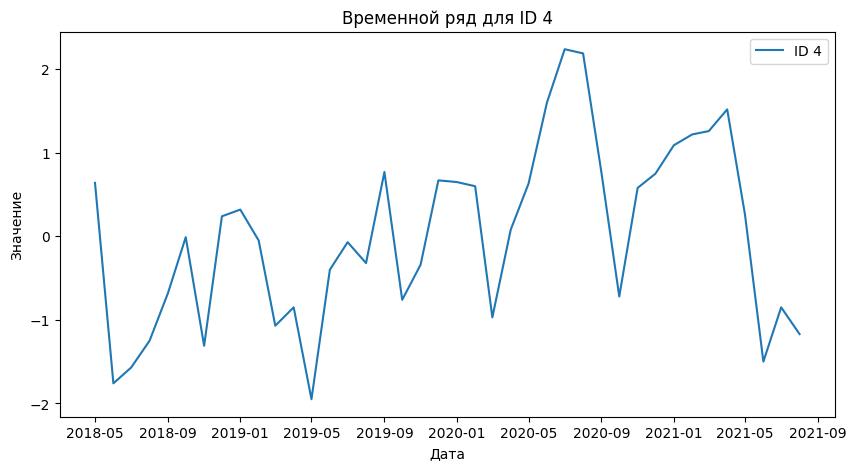

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 5')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

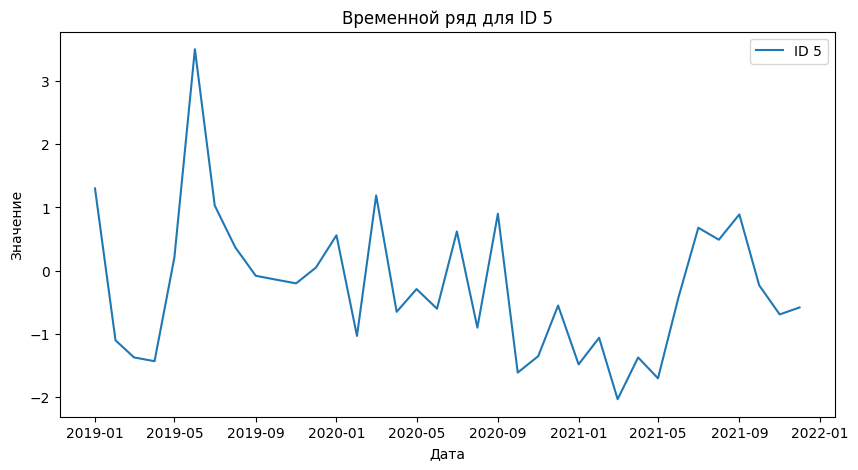

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 8')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

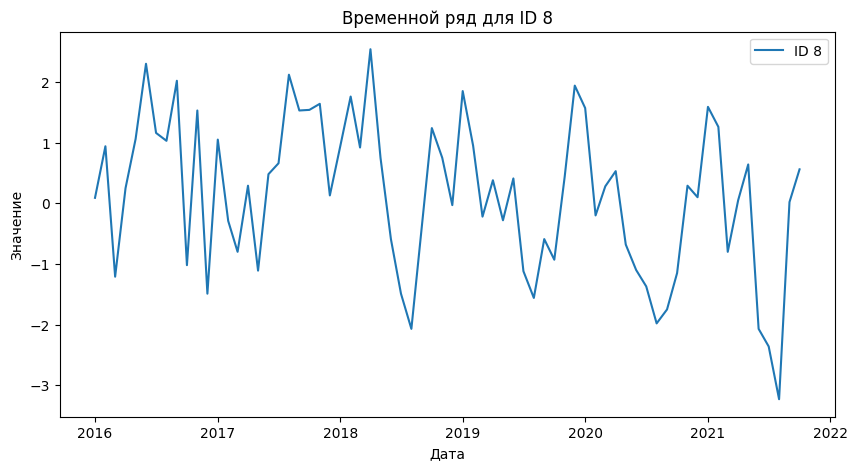

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 9')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

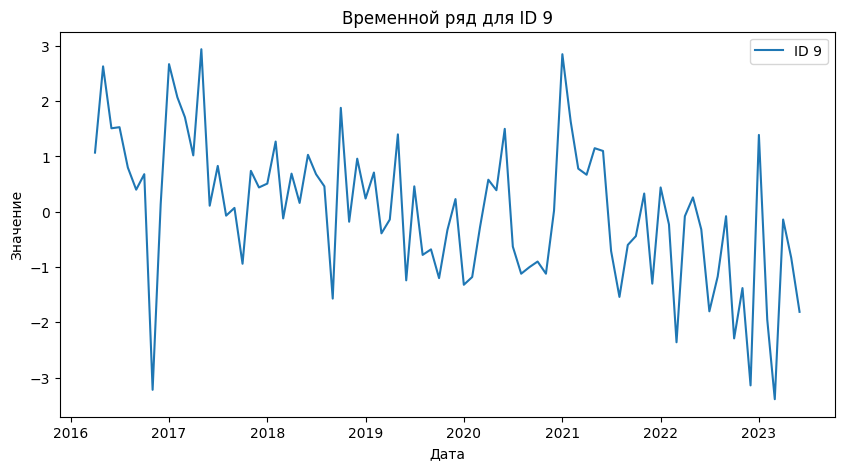

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 10')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

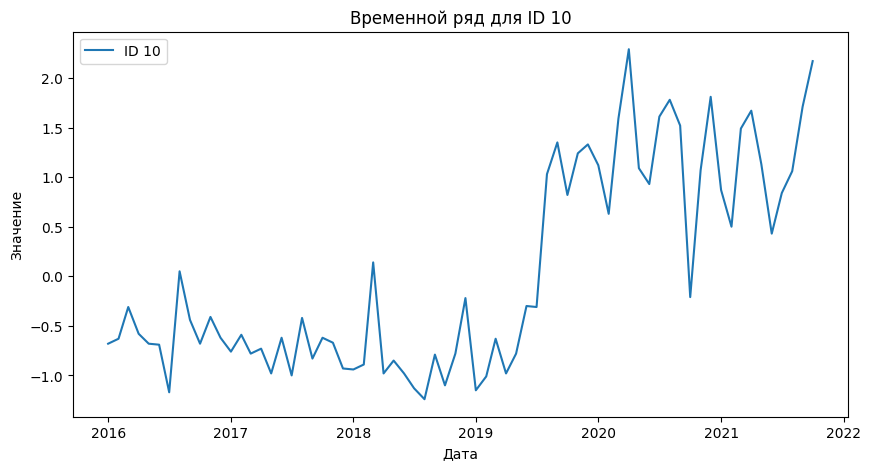

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 11')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

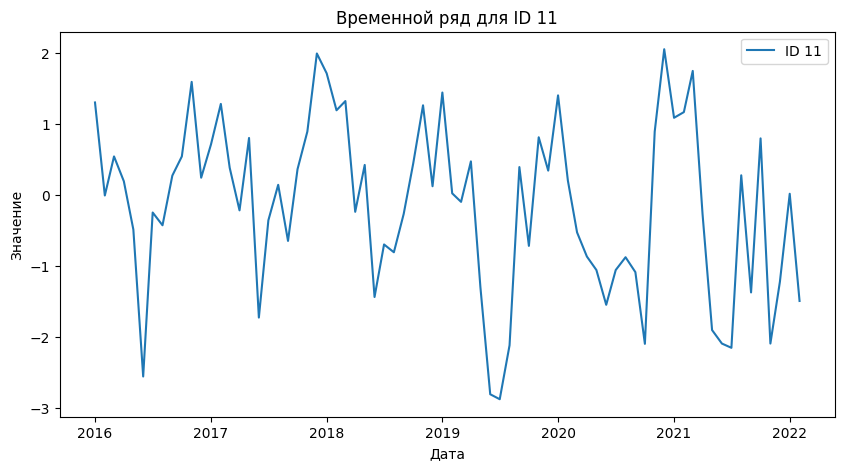

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 12')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

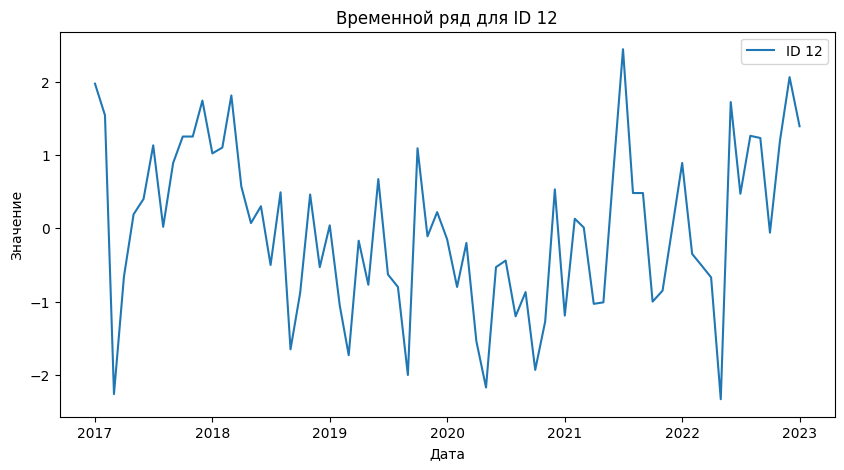

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Временной ряд для ID 14')

Text(0.5, 0, 'Дата')

Text(0, 0.5, 'Значение')

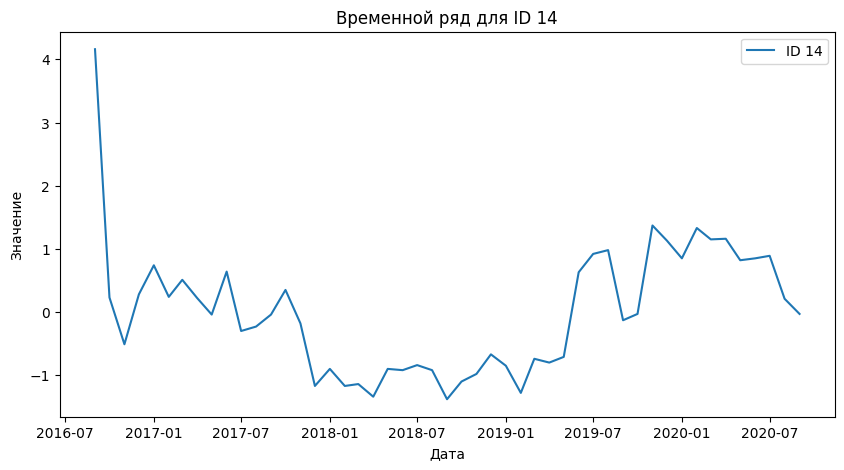

In [176]:
i = 0
for key, group in grouped:
    plt.figure(figsize=(10, 5))
    plt.plot(group['date'], group['value'], label=f'ID {key}')
    plt.title(f'Временной ряд для ID {key}')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
    i += 1
    if i > 10:
        break

Теперь сделаем декомпозицию временных рядов.

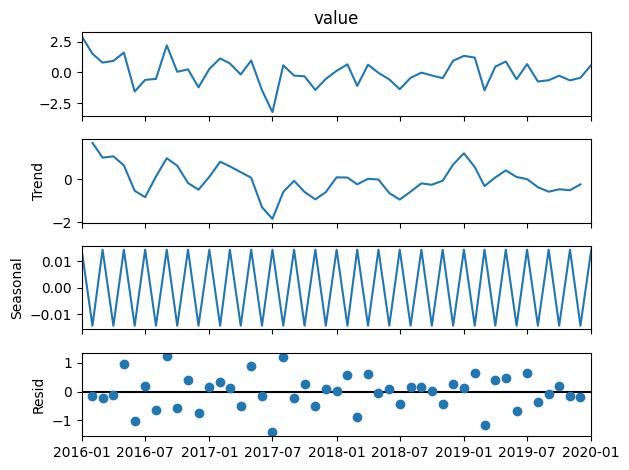

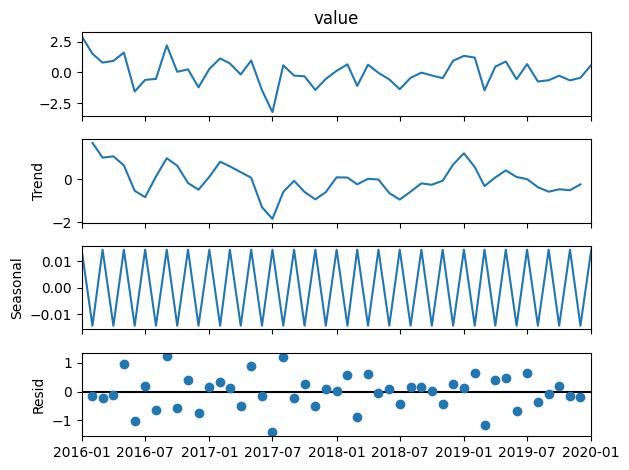

In [177]:
df_n = df_new_pd.sort_values(by=['id', 'date'])
df_n.set_index('date', inplace=True)
time_series = df_n[df_n['id'] == 1]['value']
decomposition = seasonal_decompose(time_series, model='additive', period= 2)
decomposition.plot()
plt.show()

Отсюда можно заметить, что максимальным и минимальным значением в value является 2,5 и -2,5 соответственно. Также тренд обладает не значительными колебаниями. В остатках можно заметить, что есть небольшие скопления около 0, что говорит о правильности описания тренда и сезонности.

## 1.5 Окончательная предобработка данных

Теперь перейдем к тому, что нужно преобразовать date к типу float, так как все значения в values имееют такой тип.

In [178]:
df_new_pd['date'] = pd.to_datetime(df_new_pd['date'])
df_new_pd['date'] = df_new_pd['date'].astype('int64') // 10**9

In [179]:
df_new_pd['date'] = df_new_pd['date'].values.astype("float64")
df_new_pd['value'] = df_new_pd['value'].values.astype("float64")

Посмотрим общую информацию о полученной таблице.

In [180]:
df_new_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5150830 entries, 0 to 5155411
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   date    float64
 2   value   float64
 3   label   float64
dtypes: float64(3), int64(1)
memory usage: 196.5 MB


Посмотрим статистические данные о распределении значений в DataFrame.

In [181]:
df_new_pd.describe()

id              date         value         label
count 5,150,830.000     5,150,830.000 5,150,830.000 5,150,830.000
mean     50,110.779 1,552,021,899.365        -0.030         0.274
std      28,865.479    58,617,979.717         1.225         0.446
min           0.000 1,451,606,400.000        -7.950         0.000
25%      25,105.000 1,504,224,000.000        -0.840         0.000
50%      50,151.000 1,548,979,200.000        -0.120         0.000
75%      75,073.000 1,593,561,600.000         0.760         1.000
max      99,999.000 1,704,067,200.000         9.540         1.000

In [182]:
df_new_pd.head()

id              date  value  label
0  19114 1,451,606,400.000 -1.860  0.000
1  19114 1,454,284,800.000  0.790  0.000
2  19114 1,456,790,400.000  1.400  0.000
3  19114 1,459,468,800.000  0.150  0.000
4  19114 1,462,060,800.000  0.000  0.000

Ввиду того, что в данном преобразовании файл является довольно большим, то проведем корреляционный анализ.

In [183]:
matrix = df_new_pd.corr()

<Axes: >

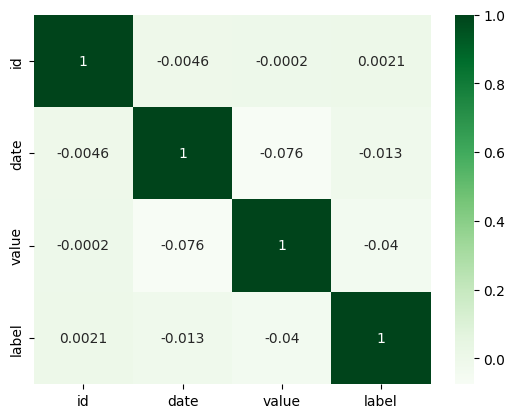

In [184]:
sns.heatmap(matrix, cmap="Greens", annot=True)

Заметим, что особо сильной зависимости между данными нет. Единсвтенная зависимость, которая выделяется из всех - это зависимость между date и value, но ее значение все равно довольно слабое.

# 2 Создание выборки и обучение моделей

## 2.1 Разбиение всех списков на строки

Перейдем к разделению выборо на тренировочную и тестовую. Target - будет столбец label, features - все остальные.

In [185]:
x = df_new_pd.drop(['label'], axis= 1)
y = df_new_pd['label']
x.shape, y.shape

((5150830, 3), (5150830,))

In [186]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 12345)

Для решения данной задачи можно использовать две модели - CatBoostClassifier и RandomForestClassifier. Необходимо обучить данные модели, получить от них предсказания и сравнить полученные значения по метрике ROC AUC. Ранее был проведен гипераметрический поиск для выбора оптимальных параметров для обеих моделей. Для CatBoost: iterations= 378, depth= 15, learning_rate= 0.3, l2_leaf_reg= 25. Для RandomForest: max_depth= 14, min_samples_leaf= 28, min_samples_split= 23, n_estimators= 290.

Рассмотрим сначала CatBoost.

In [187]:
cat_model = CatBoostClassifier(iterations= 378, depth= 15, learning_rate= 0.3, l2_leaf_reg= 25, custom_metric='AUC')

In [188]:
cat_model.fit(x_train, y_train)

0:	learn: 0.6349779	total: 656ms	remaining: 4m 7s
1:	learn: 0.6076014	total: 1.4s	remaining: 4m 22s
2:	learn: 0.5944274	total: 1.98s	remaining: 4m 7s
3:	learn: 0.5881138	total: 2.52s	remaining: 3m 56s
4:	learn: 0.5850729	total: 3.08s	remaining: 3m 49s
5:	learn: 0.5835566	total: 3.78s	remaining: 3m 54s
6:	learn: 0.5828013	total: 4.42s	remaining: 3m 54s
7:	learn: 0.5823904	total: 4.9s	remaining: 3m 46s
8:	learn: 0.5821639	total: 5.54s	remaining: 3m 47s
9:	learn: 0.5820256	total: 6.17s	remaining: 3m 47s
10:	learn: 0.5819334	total: 6.82s	remaining: 3m 47s
11:	learn: 0.5818546	total: 7.44s	remaining: 3m 46s
12:	learn: 0.5817368	total: 8.07s	remaining: 3m 46s
13:	learn: 0.5816626	total: 8.7s	remaining: 3m 46s
14:	learn: 0.5815584	total: 9.33s	remaining: 3m 45s
15:	learn: 0.5815103	total: 9.95s	remaining: 3m 45s
16:	learn: 0.5814267	total: 10.6s	remaining: 3m 44s
17:	learn: 0.5813546	total: 11.2s	remaining: 3m 44s
18:	learn: 0.5812913	total: 11.7s	remaining: 3m 41s
19:	learn: 0.5812435	total:

In [189]:
joblib.dump(cat_model,'cat_model')

['cat_model']

In [190]:
y_pred_proba = cat_model.predict_proba(x_test)[:, 1]

In [191]:
y_pred = cat_model.predict(x_test)

Теперь посмотрим на график нашей кривой.

In [192]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

In [193]:
eval_pool = Pool(x_test, y_test)
(fpr, tpr, thresholds) = get_roc_curve(cat_model, eval_pool)
roc_auc = auc(fpr, tpr)

<Figure size 500x500 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

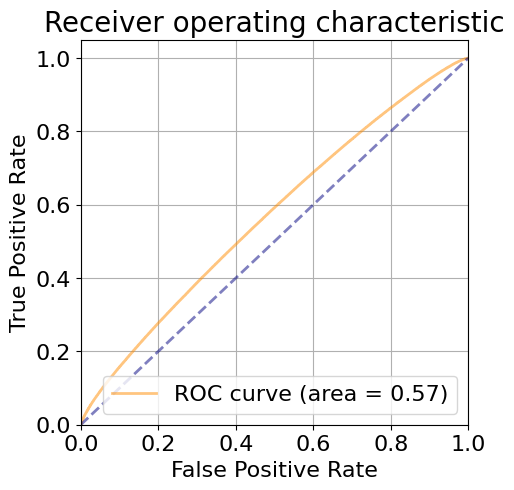

In [194]:
plt.figure(figsize=(5, 5))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Из графика видим, что показатель ROC AUC довольно низкий и очень близок к 0,5. Рассмотрим теперь RandomForestClassifier.

In [195]:
f_model = RandomForestClassifier(max_depth= 14, min_samples_leaf= 28, min_samples_split= 23, n_estimators= 290)

In [196]:
f_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=23,
                       n_estimators=290)

In [197]:
joblib.dump(f_model,'f_model')

['f_model']

In [198]:
y_predict = f_model.predict_proba(x_test)[:, 1]

In [199]:
roc_auc = roc_auc_score(y_test, y_predict) 
roc_auc

0.5657753669460813

In [200]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

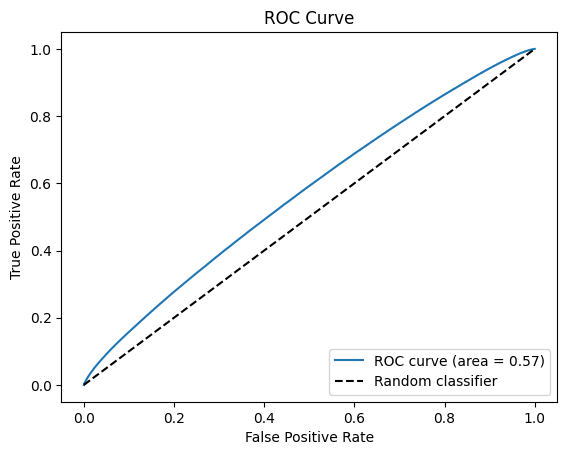

In [201]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()

Также получаем, что у этой модели ROC AUC = 0,57.
Перейдем ко второму варианту обработки данных.

## 2.2 Конвертирование списков в пары столбец:значение

Рассмотрим теперь второй вариант обработки данных, когда будут браться все уникальные значения из список с датами dates и делаться столбцами, а соответствующие из values будут значениями в этом столбце.
Также во втором случае обработаем исходный файл с помощью pandas.

In [202]:
dt = pd.read_parquet('train.parquet')

In [203]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [204]:
dt.head()

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....  0.000  
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...  1.000  
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...  0.000  
3  [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...  0.000  
4  [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...  0.000

In [205]:
new_dt = dt

In [206]:
all_unique_dates = sorted(set([date for sublist in new_dt['dates'] for date in sublist]))
for date in all_unique_dates:
    new_dt[date] = np.nan
for index, row in new_dt.iterrows():
    for date, value in zip(row['dates'], row['values']):
        new_dt.at[index, date] = value

In [207]:
new_dt.head()

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  2016-01-01  \
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....  0.000      -1.860   
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...  1.000         NaN   
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...  0.000         NaN   
3  [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...  0.000      -0.330   
4  [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...  0.000       1.310   

   2016-02-01  2016-03-01  2016-04-01  2016-05-01  2016-06-01  ...  \
0       0.790       1.400       0.150       0.000      -1.240  ...   
1         NaN         NaN         NaN      -1.040      -3.480  ...   
2         NaN         NaN         NaN         NaN         NaN  ...   
3       0.580       1.100      -0.560      -0.950      -0.610  ...   
4       0.500      -0.540       0.950       0.650       0.830  ...   

   2023-04-01  2023-05-01  2023-06-01  2023-07-01  2023-08-01  2023-09-01  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2023-10-01  2023-11-01  2023-12-01  2024-01-01  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN  

[5 rows x 101 columns]

In [208]:
new_dt = new_dt.drop(columns=['dates', 'values'])

In [209]:
new_dt.head()

id  label  2016-01-01  2016-02-01  2016-03-01  2016-04-01  2016-05-01  \
0  19114  0.000      -1.860       0.790       1.400       0.150       0.000   
1  22769  1.000         NaN         NaN         NaN         NaN      -1.040   
2  76935  0.000         NaN         NaN         NaN         NaN         NaN   
3  66297  0.000      -0.330       0.580       1.100      -0.560      -0.950   
4   2191  0.000       1.310       0.500      -0.540       0.950       0.650   

   2016-06-01  2016-07-01  2016-08-01  ...  2023-04-01  2023-05-01  \
0      -1.240      -1.460       3.490  ...         NaN         NaN   
1      -3.480       0.050      -0.130  ...         NaN         NaN   
2         NaN         NaN         NaN  ...         NaN         NaN   
3      -0.610      -0.700      -1.350  ...         NaN         NaN   
4       0.830      -1.550      -0.280  ...         NaN         NaN   

   2023-06-01  2023-07-01  2023-08-01  2023-09-01  2023-10-01  2023-11-01  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2023-12-01  2024-01-01  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN  

[5 rows x 99 columns]

In [210]:
new_dt.columns = new_dt.columns.astype(str)

In [211]:
new_dt.isna().sum()

id                0
label             0
2016-01-01    34313
2016-02-01    27217
2016-03-01    24613
2016-04-01    22806
2016-05-01    21600
2016-06-01    20832
2016-07-01    19805
2016-08-01    19187
2016-09-01    18536
2016-10-01    17841
2016-11-01    17231
2016-12-01    16736
2017-01-01    13257
2017-02-01    12405
2017-03-01    11732
2017-04-01    11126
2017-05-01    10590
2017-06-01    10018
2017-07-01     9606
2017-08-01     9175
2017-09-01     8802
2017-10-01     8244
2017-11-01     7831
2017-12-01     7482
2018-01-01     6967
2018-02-01     6658
2018-03-01     6306
2018-04-01     5918
2018-05-01     5564
2018-06-01     5254
2018-07-01     4980
2018-08-01     4712
2018-09-01     4502
2018-10-01     4231
2018-11-01     4001
2018-12-01     3713
2019-01-01     3390
2019-02-01     3116
2019-03-01     2903
2019-04-01     2666
2019-05-01     2445
2019-06-01     2261
2019-07-01     2074
2019-08-01     1910
2019-09-01     1747
2019-10-01     1483
2019-11-01     1228
2019-12-01     1110


In [212]:
new_dt.isnull().mean() * 100

id            0.000
label         0.000
2016-01-01   42.891
2016-02-01   34.021
2016-03-01   30.766
2016-04-01   28.508
2016-05-01   27.000
2016-06-01   26.040
2016-07-01   24.756
2016-08-01   23.984
2016-09-01   23.170
2016-10-01   22.301
2016-11-01   21.539
2016-12-01   20.920
2017-01-01   16.571
2017-02-01   15.506
2017-03-01   14.665
2017-04-01   13.908
2017-05-01   13.237
2017-06-01   12.523
2017-07-01   12.008
2017-08-01   11.469
2017-09-01   11.002
2017-10-01   10.305
2017-11-01    9.789
2017-12-01    9.352
2018-01-01    8.709
2018-02-01    8.322
2018-03-01    7.883
2018-04-01    7.397
2018-05-01    6.955
2018-06-01    6.567
2018-07-01    6.225
2018-08-01    5.890
2018-09-01    5.627
2018-10-01    5.289
2018-11-01    5.001
2018-12-01    4.641
2019-01-01    4.238
2019-02-01    3.895
2019-03-01    3.629
2019-04-01    3.333
2019-05-01    3.056
2019-06-01    2.826
2019-07-01    2.592
2019-08-01    2.388
2019-09-01    2.184
2019-10-01    1.854
2019-11-01    1.535
2019-12-01    1.387


Заметим, что присутствует очень много столбцов, где содержится довольно большое количество пропусков, вплоть почти до 98 процентов. Поэтому удалим столбцы, в которых более 50 процентов пропусков.

In [231]:
n_dt_50 = new_dt.drop(list(new_dt.columns[70:99]), axis= 1)

In [232]:
n_dt_50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          80000 non-null  int64  
 1   label       80000 non-null  float64
 2   2016-01-01  45687 non-null  float64
 3   2016-02-01  52783 non-null  float64
 4   2016-03-01  55387 non-null  float64
 5   2016-04-01  57194 non-null  float64
 6   2016-05-01  58400 non-null  float64
 7   2016-06-01  59168 non-null  float64
 8   2016-07-01  60195 non-null  float64
 9   2016-08-01  60813 non-null  float64
 10  2016-09-01  61464 non-null  float64
 11  2016-10-01  62159 non-null  float64
 12  2016-11-01  62769 non-null  float64
 13  2016-12-01  63264 non-null  float64
 14  2017-01-01  66743 non-null  float64
 15  2017-02-01  67595 non-null  float64
 16  2017-03-01  68268 non-null  float64
 17  2017-04-01  68874 non-null  float64
 18  2017-05-01  69410 non-null  float64
 19  2017-06-01  69982 non-nul

In [233]:
n_dt_50.isnull().mean() * 100

id            0.000
label         0.000
2016-01-01   42.891
2016-02-01   34.021
2016-03-01   30.766
2016-04-01   28.508
2016-05-01   27.000
2016-06-01   26.040
2016-07-01   24.756
2016-08-01   23.984
2016-09-01   23.170
2016-10-01   22.301
2016-11-01   21.539
2016-12-01   20.920
2017-01-01   16.571
2017-02-01   15.506
2017-03-01   14.665
2017-04-01   13.908
2017-05-01   13.237
2017-06-01   12.523
2017-07-01   12.008
2017-08-01   11.469
2017-09-01   11.002
2017-10-01   10.305
2017-11-01    9.789
2017-12-01    9.352
2018-01-01    8.709
2018-02-01    8.322
2018-03-01    7.883
2018-04-01    7.397
2018-05-01    6.955
2018-06-01    6.567
2018-07-01    6.225
2018-08-01    5.890
2018-09-01    5.627
2018-10-01    5.289
2018-11-01    5.001
2018-12-01    4.641
2019-01-01    4.238
2019-02-01    3.895
2019-03-01    3.629
2019-04-01    3.333
2019-05-01    3.056
2019-06-01    2.826
2019-07-01    2.592
2019-08-01    2.388
2019-09-01    2.184
2019-10-01    1.854
2019-11-01    1.535
2019-12-01    1.387


Теперь заполним оставшиеся пропуски средними значениями по этим столбцам

In [234]:
n_dt_50.fillna(n_dt_50.mean(), inplace= True)

In [235]:
n_dt_50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          80000 non-null  int64  
 1   label       80000 non-null  float64
 2   2016-01-01  80000 non-null  float64
 3   2016-02-01  80000 non-null  float64
 4   2016-03-01  80000 non-null  float64
 5   2016-04-01  80000 non-null  float64
 6   2016-05-01  80000 non-null  float64
 7   2016-06-01  80000 non-null  float64
 8   2016-07-01  80000 non-null  float64
 9   2016-08-01  80000 non-null  float64
 10  2016-09-01  80000 non-null  float64
 11  2016-10-01  80000 non-null  float64
 12  2016-11-01  80000 non-null  float64
 13  2016-12-01  80000 non-null  float64
 14  2017-01-01  80000 non-null  float64
 15  2017-02-01  80000 non-null  float64
 16  2017-03-01  80000 non-null  float64
 17  2017-04-01  80000 non-null  float64
 18  2017-05-01  80000 non-null  float64
 19  2017-06-01  80000 non-nul

Проведем теперь анализ получившегося DataFrame.

In [236]:
matr = n_dt_50.corr()

<Figure size 9000x8500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

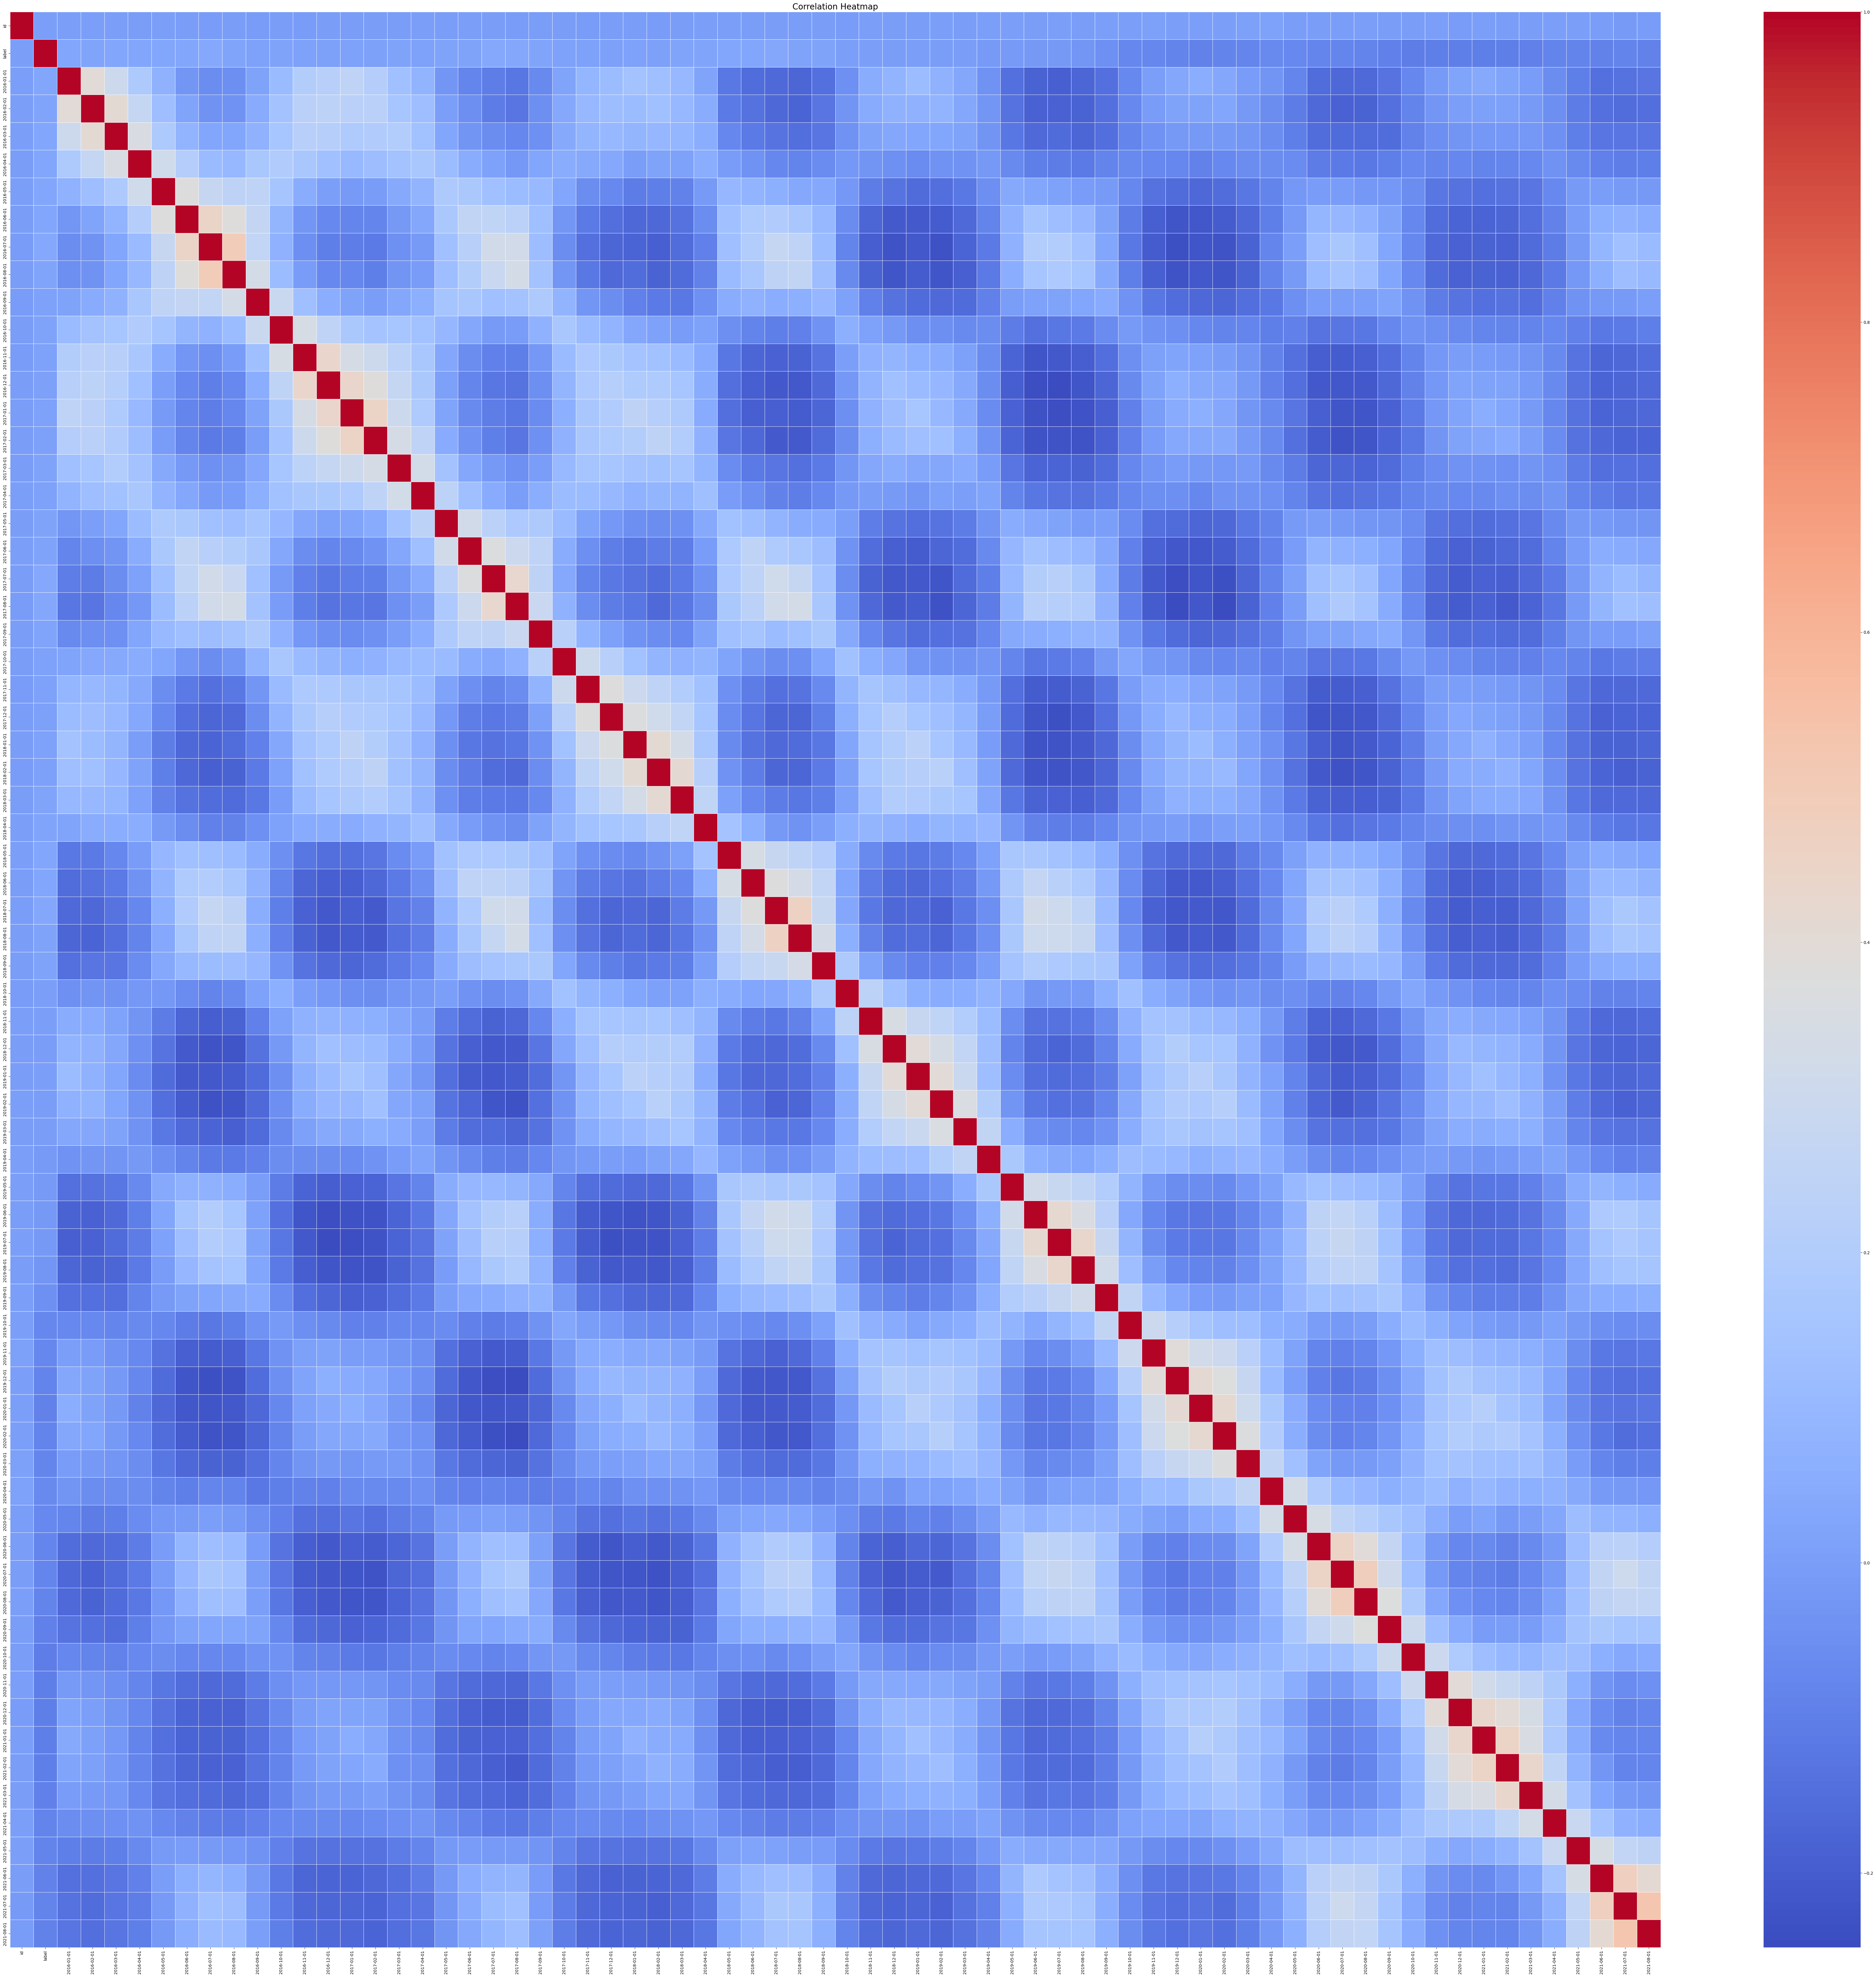

In [237]:
plt.figure(figsize=(90, 85))
sns.heatmap(matr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

Как можно сделать вывод, что все столбцы особо сильно не коррелируют друг с другом. Здесь в целом у столбцов слабая корреляция, но можно выбрать и те, у которых она отличается сильно, на фоне остальных, но является все равно довольно слабой - между 0.4 и 0.5. Поэтому для дальнейшего анализа будут выбраны эти столбцы.

In [238]:
f_matr = matr.where(np.triu(np.ones(matr.shape), k=1).astype(bool))
rows, cols = np.where(f_matr > 0.4)
columns_above_threshold = set(f_matr.index[rows]).union(set(f_matr.columns[cols]))
columns_to_keep = ['id', 'label'] + [col for col in matr.columns if col in columns_above_threshold]
df_filt = n_dt_50[columns_to_keep]

In [239]:
# f_matr = matr.where(np.triu(np.ones(matr.shape), k=1).astype(bool))
# columns_above_threshold = f_matr.columns[(f_matr > 0.4).any()]
# columns_to_keep = ['id', 'label'] + list(columns_above_threshold)
# df_filt = n_dt_50[columns_to_keep]

In [240]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          80000 non-null  int64  
 1   label       80000 non-null  float64
 2   2016-02-01  80000 non-null  float64
 3   2016-03-01  80000 non-null  float64
 4   2016-06-01  80000 non-null  float64
 5   2016-07-01  80000 non-null  float64
 6   2016-08-01  80000 non-null  float64
 7   2016-11-01  80000 non-null  float64
 8   2016-12-01  80000 non-null  float64
 9   2017-01-01  80000 non-null  float64
 10  2017-02-01  80000 non-null  float64
 11  2017-07-01  80000 non-null  float64
 12  2017-08-01  80000 non-null  float64
 13  2018-01-01  80000 non-null  float64
 14  2018-02-01  80000 non-null  float64
 15  2018-03-01  80000 non-null  float64
 16  2018-07-01  80000 non-null  float64
 17  2018-08-01  80000 non-null  float64
 18  2018-12-01  80000 non-null  float64
 19  2019-01-01  80000 non-nul

<Figure size 3000x2500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

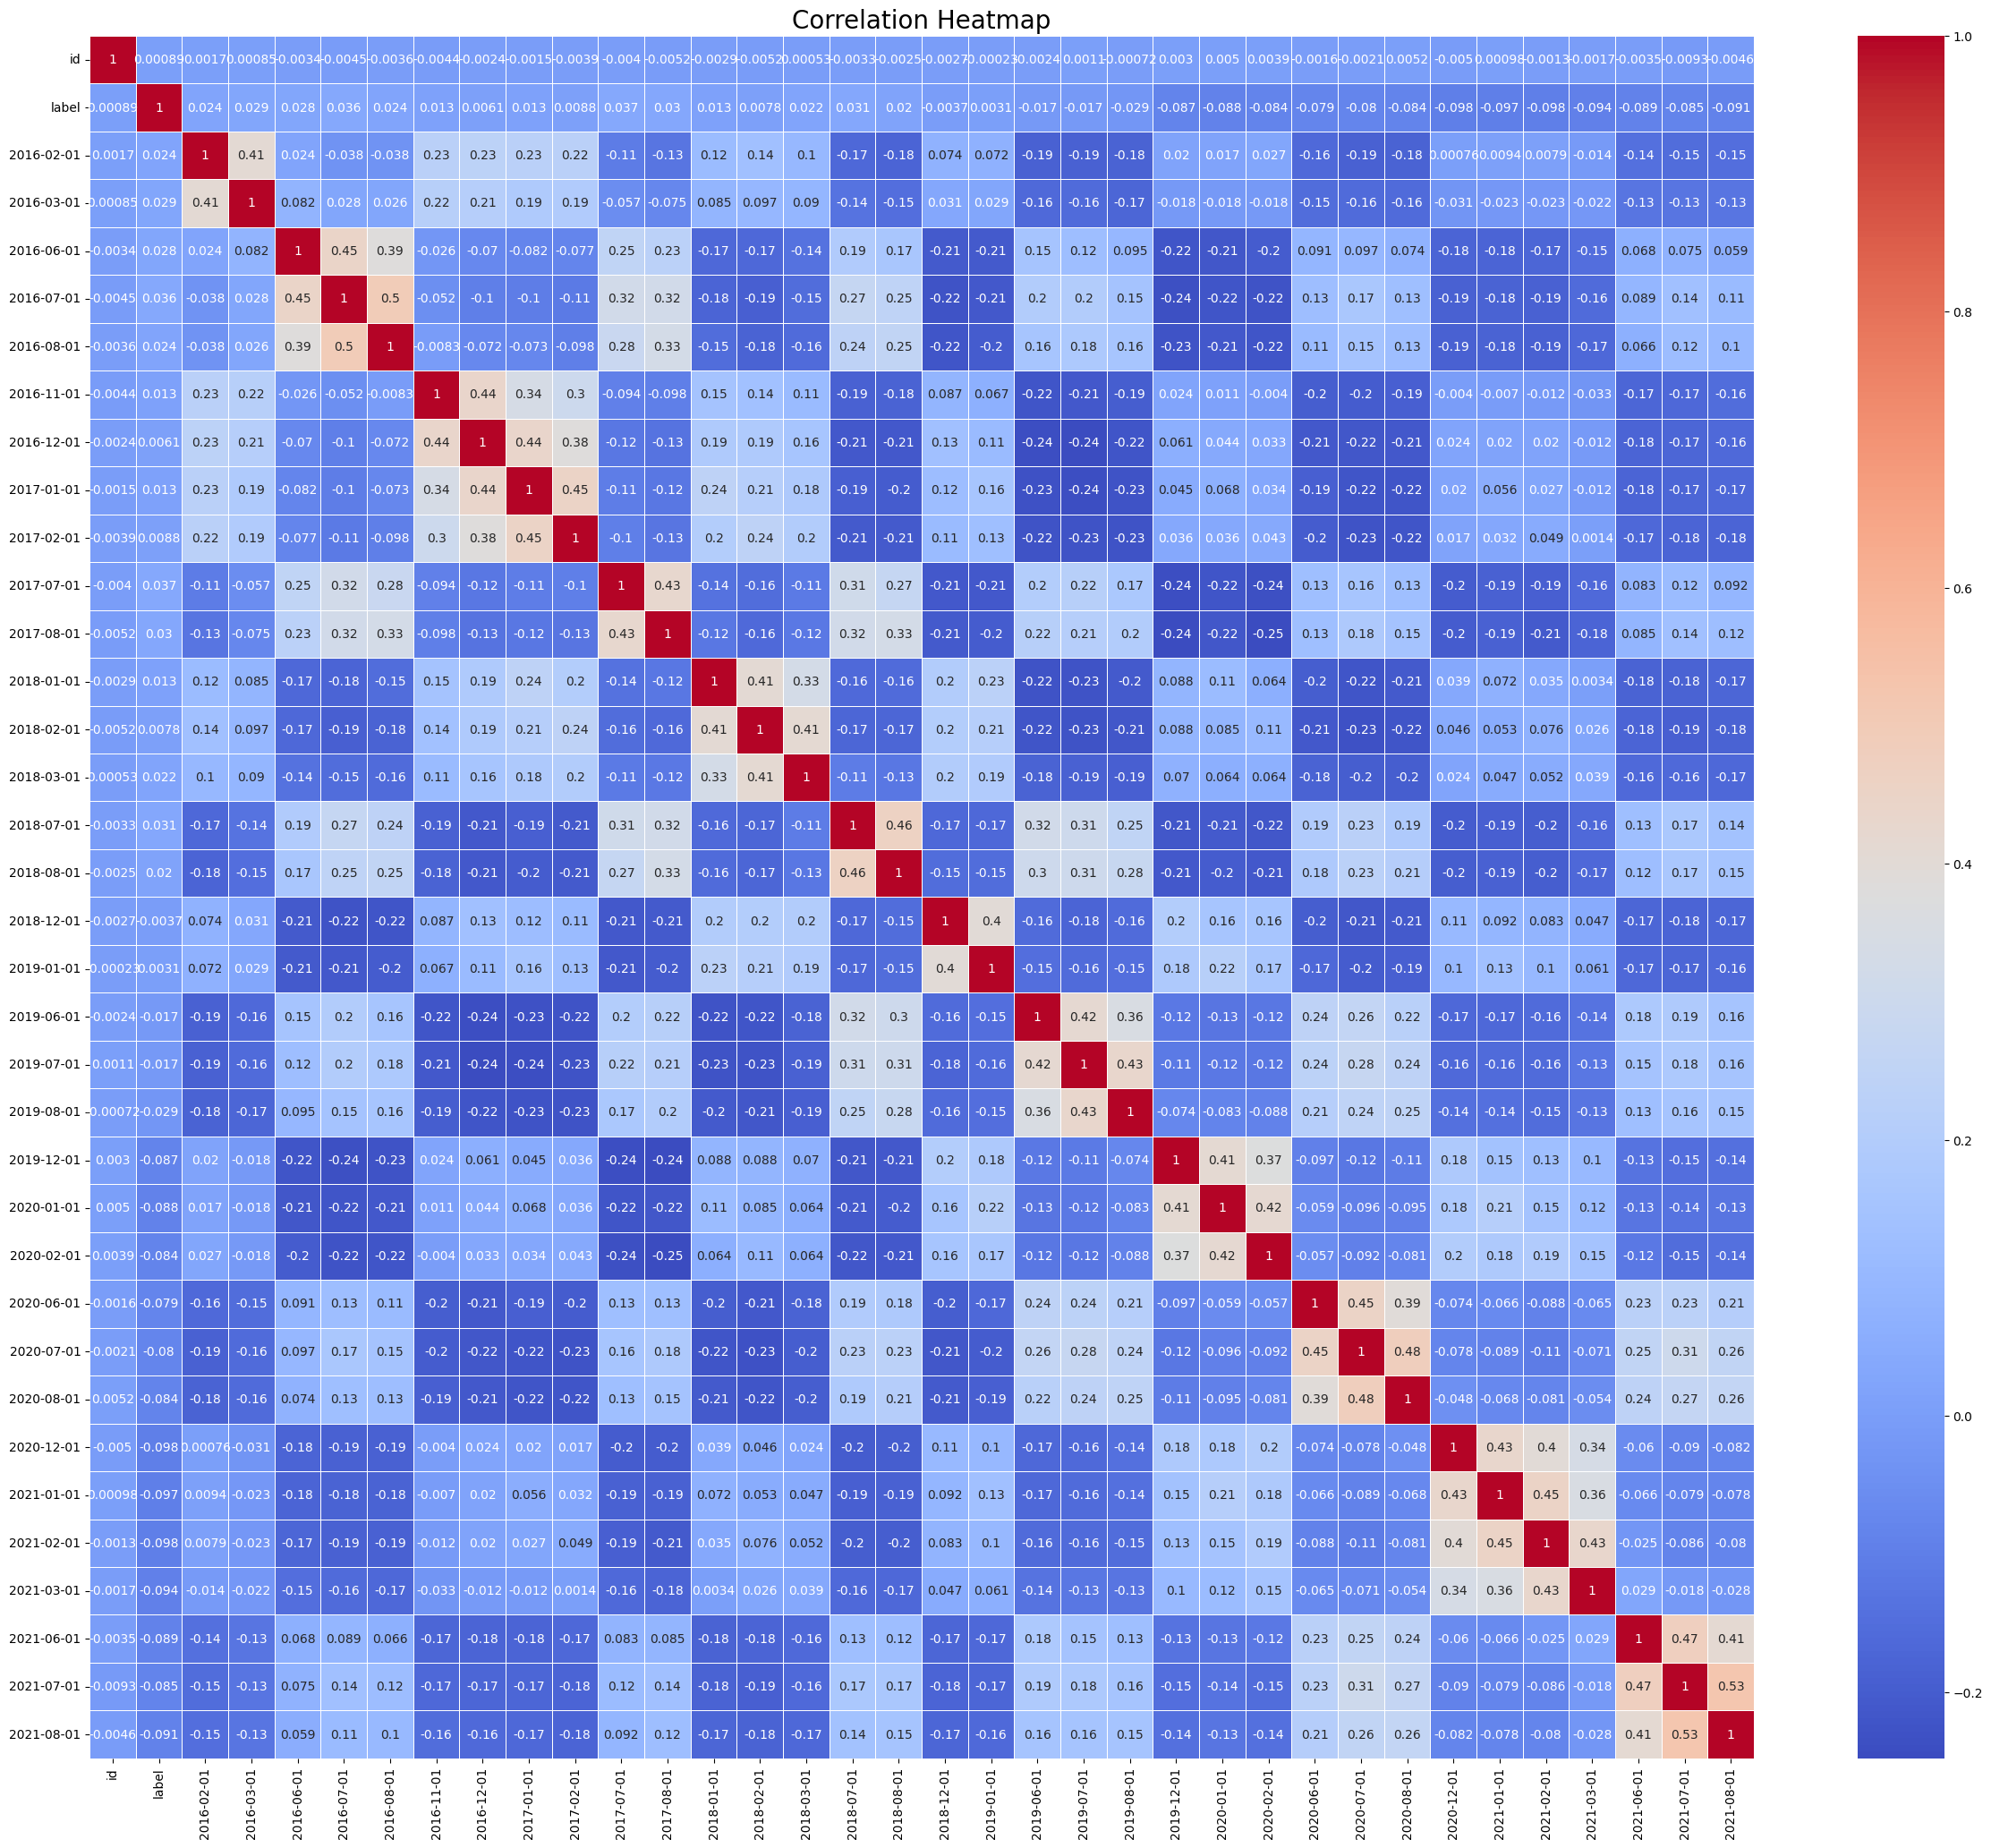

In [241]:
plt.figure(figsize=(30, 25))
sns.heatmap(df_filt.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

Таким образом, сейчас мы получили все нужные столбцы, которые лучше всего коррелируют друг с другом.
Разделим выборку на тренировочную и тестовую.

In [242]:
x_f = df_filt.drop(['label'], axis= 1)
y_f = df_filt['label']

In [243]:
x_f_train, x_f_test, y_f_train, y_f_test = train_test_split(x_f, y_f, test_size= .3, random_state= 12345)

In [93]:
params_grid = {
    'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 400, num = 30)],
    'max_depth' : [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)],
    'min_samples_split' : [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
    'min_samples_leaf' : [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
}

In [94]:
dt_model = RandomForestClassifier()
rand_search = RandomizedSearchCV(dt_model, params_grid, error_score='raise', cv= 3, verbose= 2)

In [95]:
rand_search.fit(x_f_train, y_f_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=2, min_samples_leaf=12, min_samples_split=44, n_estimators=213; total time=   4.7s
[CV] END max_depth=2, min_samples_leaf=12, min_samples_split=44, n_estimators=213; total time=   4.6s
[CV] END max_depth=2, min_samples_leaf=12, min_samples_split=44, n_estimators=213; total time=   4.6s
[CV] END max_depth=13, min_samples_leaf=23, min_samples_split=28, n_estimators=100; total time=  11.3s
[CV] END max_depth=13, min_samples_leaf=23, min_samples_split=28, n_estimators=100; total time=  11.3s
[CV] END max_depth=13, min_samples_leaf=23, min_samples_split=28, n_estimators=100; total time=  11.0s
[CV] END max_depth=8, min_samples_leaf=12, min_samples_split=7, n_estimators=348; total time=  26.0s
[CV] END max_depth=8, min_samples_leaf=12, min_samples_split=7, n_estimators=348; total time=  26.1s
[CV] END max_depth=8, min_samples_leaf=12, min_samples_split=7, n_estimators=348; total time=  26.4s
[CV] END max_depth=10

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'min_samples_leaf': [2, 7, 12, 18, 23,
                                                             28, 34, 39, 44,
                                                             50],
                                        'min_samples_split': [2, 7, 12, 18, 23,
                                                              28, 34, 39, 44,
                                                              50],
                                        'n_estimators': [100, 110, 120, 131,
                                                         141, 151, 162, 172,
                                                         182, 193, 203, 213,
                                                         224, 234, 244, 255,
                                                         265, 275, 286, 296,
                                                         306, 317, 327, 337,
                                                         348, 358, 368, 379,
                                                         389, 400]},
                   verbose=2)

In [96]:
rand_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 28,
 'min_samples_leaf': 23,
 'max_depth': 13}

In [244]:
dt_model_f = RandomForestClassifier(n_estimators= 100, min_samples_split= 28, min_samples_leaf= 23, max_depth= 13)

In [245]:
dt_model_f.fit(x_f_train, y_f_train)

RandomForestClassifier(max_depth=13, min_samples_leaf=23, min_samples_split=28)

In [246]:
joblib.dump(dt_model_f,'dt_model_f')

['dt_model_f']

In [247]:
y_pred = dt_model_f.predict_proba(x_f_test)[:, 1]

In [248]:
roc_auc_rf = roc_auc_score(y_f_test, y_pred) 
roc_auc_rf

0.7217981272177862

<Figure size 640x480 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC-кривая')

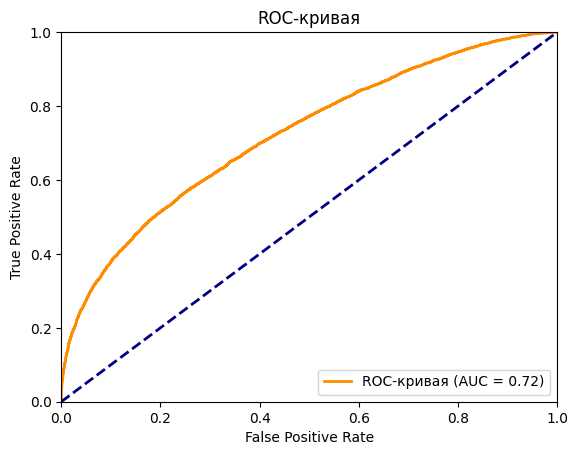

In [249]:
fpr, tpr, thresholds = roc_curve(y_f_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Мы видим, что модель имеет довольно высокий показатель ROC AUC. Теперь проверим модель CatBoost.

In [250]:
params_rand = {
    'iterations' : [int(x) for x in np.linspace(start = 200, stop = 400, num = 20)],
    'depth' : [int(x) for x in np.linspace(start = 5, stop = 15, num = 5)],
    'learning_rate' : [x for x in np.linspace(start = 0.1, stop = 0.3, num = 5)],
    'l2_leaf_reg' : [int(x) for x in np.linspace(start = 2, stop = 30, num = 7)]
}

In [104]:
c_model = CatBoostClassifier(custom_metric='AUC')
rand_search_с = RandomizedSearchCV(c_model, params_rand, error_score='raise', cv= 3, verbose= 2)

In [107]:
rand_search_с.fit(x_f_train, y_f_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6265266	total: 132ms	remaining: 38.6s
1:	learn: 0.5811008	total: 269ms	remaining: 39.2s
2:	learn: 0.5509864	total: 401ms	remaining: 38.8s
3:	learn: 0.5287053	total: 538ms	remaining: 39s
4:	learn: 0.5139214	total: 669ms	remaining: 38.7s
5:	learn: 0.5050580	total: 798ms	remaining: 38.3s
6:	learn: 0.4954369	total: 932ms	remaining: 38.2s
7:	learn: 0.4863174	total: 1.06s	remaining: 38.1s
8:	learn: 0.4783286	total: 1.2s	remaining: 38.1s
9:	learn: 0.4688155	total: 1.33s	remaining: 37.8s
10:	learn: 0.4623794	total: 1.47s	remaining: 37.7s
11:	learn: 0.4553221	total: 1.6s	remaining: 37.6s
12:	learn: 0.4502481	total: 1.73s	remaining: 37.4s
13:	learn: 0.4443238	total: 1.86s	remaining: 37.2s
14:	learn: 0.4370200	total: 1.99s	remaining: 37.1s
15:	learn: 0.4318467	total: 2.13s	remaining: 36.9s
16:	learn: 0.4269286	total: 2.25s	remaining: 36.7s
17:	learn: 0.4221127	total: 2.38s	remaining: 36.6s
18:	learn: 0.4184607	total: 2.52s	r

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x75811229c380>,
                   param_distributions={'depth': [5, 7, 10, 12, 15],
                                        'iterations': [200, 210, 221, 231, 242,
                                                       252, 263, 273, 284, 294,
                                                       305, 315, 326, 336, 347,
                                                       357, 368, 378, 389,
                                                       400],
                                        'l2_leaf_reg': [2, 6, 11, 16, 20, 25,
                                                        30],
                                        'learning_rate': [0.1, 0.15, 0.2, 0.25,
                                                          0.3]},
                   verbose=2)

In [108]:
c_m_f = rand_search_с.best_params_
c_m_f

{'learning_rate': 0.1, 'l2_leaf_reg': 30, 'iterations': 305, 'depth': 10}

{'learning_rate': 0.1, 'l2_leaf_reg': 16, 'iterations': 315, 'depth': 5}

In [291]:
c_model_t = CatBoostClassifier(learning_rate= 0.1, l2_leaf_reg= 30, iterations= 305, depth= 10, custom_metric='AUC')

In [292]:
c_model_t.fit(x_f_train, y_f_train)

0:	learn: 0.6673015	total: 45.1ms	remaining: 13.7s
1:	learn: 0.6476056	total: 88.7ms	remaining: 13.4s
2:	learn: 0.6293798	total: 133ms	remaining: 13.3s
3:	learn: 0.6139383	total: 175ms	remaining: 13.1s
4:	learn: 0.6018957	total: 219ms	remaining: 13.1s
5:	learn: 0.5905741	total: 261ms	remaining: 13s
6:	learn: 0.5814846	total: 305ms	remaining: 13s
7:	learn: 0.5728554	total: 349ms	remaining: 12.9s
8:	learn: 0.5663036	total: 394ms	remaining: 13s
9:	learn: 0.5602612	total: 438ms	remaining: 12.9s
10:	learn: 0.5551831	total: 482ms	remaining: 12.9s
11:	learn: 0.5512478	total: 526ms	remaining: 12.8s
12:	learn: 0.5473886	total: 571ms	remaining: 12.8s
13:	learn: 0.5438373	total: 615ms	remaining: 12.8s
14:	learn: 0.5408504	total: 659ms	remaining: 12.7s
15:	learn: 0.5380820	total: 703ms	remaining: 12.7s
16:	learn: 0.5352878	total: 747ms	remaining: 12.7s
17:	learn: 0.5329245	total: 792ms	remaining: 12.6s
18:	learn: 0.5305420	total: 836ms	remaining: 12.6s
19:	learn: 0.5283673	total: 882ms	remaining: 

In [293]:
joblib.dump(c_model_t,'c_model_t')

['c_model_t']

In [294]:
y_predict_prob = c_model_t.predict_proba(x_f_test)[:, 1]

In [295]:
fpr, tpr, thresholds = roc_curve(y_f_test, y_predict_prob, pos_label=1)

In [296]:
eval_pool = Pool(x_f_test, y_f_test)
(fpr, tpr, thresholds) = get_roc_curve(c_model_t, eval_pool)
roc_auc = auc(fpr, tpr)

In [297]:
roc_auc

0.7374326430371465

<Figure size 500x500 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

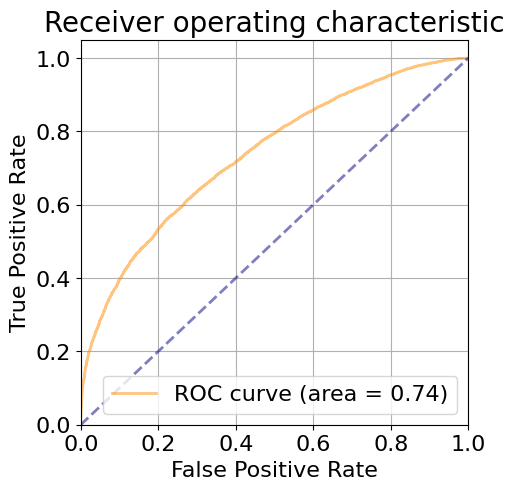

In [298]:
plt.figure(figsize=(5, 5))
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Видим, что полученная метрика ROC AUC ≈ 0,74, что немного больше чем у модели RandomForestClassifier.

Анализируя оба варианта решения получается, что верным вариантом преобразования данных будет преобразование уникальных дат в столбцы и заполнение их соответствующим значением. После анализа всех столбцов необходимо было исключить те, которые содержат большое количество пропусков. Для последующей обработки данных был произведен корреляционный анализ в ходе которого были взяты только те столбцы, у которых корреляция больше или равно 0,4.

# 3 Предсказания на тестовой выборке

Перед тем как перейти к предсказаниям на тестовой выборке, сначала нужно обработать данные и провести анализ. Воспользуемся таким же алгоритмом как на тренировочной выборке.

In [259]:
dp = pd.read_parquet('test.parquet')

In [260]:
dp.head()

id                                              dates  \
0   6125  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  26781  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
2  13333  [2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...   
3  53218  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4  84204  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  
0  [1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91...  
1  [-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,...  
2  [-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,...  
3  [-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1...  
4  [2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1...

In [261]:
dp_f = dp

In [262]:
all_unique_dates = sorted(set([date for sublist in dp_f['dates'] for date in sublist]))
for date in all_unique_dates:
    dp_f[date] = np.nan
for index, row in dp_f.iterrows():
    for date, value in zip(row['dates'], row['values']):
        dp_f.at[index, date] = value

In [263]:
dp_f.head()

id                                              dates  \
0   6125  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  26781  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
2  13333  [2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...   
3  53218  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4  84204  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  2016-01-01  2016-02-01  \
0  [1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91...       1.850      -0.040   
1  [-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,...      -0.410       0.390   
2  [-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,...         NaN         NaN   
3  [-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1...      -1.470       1.550   
4  [2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1...       2.330       1.390   

   2016-03-01  2016-04-01  2016-05-01  2016-06-01  2016-07-01  ...  \
0       0.190      -0.450      -0.750      -0.950      -2.910  ...   
1      -0.470      -0.900      -1.460      -0.510       0.510  ...   
2         NaN         NaN         NaN      -0.290      -1.260  ...   
3      -0.030       0.570      -0.570       0.600       0.270  ...   
4      -1.030      -2.640       1.890       1.770       1.430  ...   

   2023-04-01  2023-05-01  2023-06-01  2023-07-01  2023-08-01  2023-09-01  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2023-10-01  2023-11-01  2023-12-01  2024-01-01  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN  

[5 rows x 100 columns]

In [264]:
dp_f = dp_f.drop(columns=['dates', 'values'])
dp_f.columns = dp_f.columns.astype(str)

In [265]:
dp_f.head()

id  2016-01-01  2016-02-01  2016-03-01  2016-04-01  2016-05-01  \
0   6125       1.850      -0.040       0.190      -0.450      -0.750   
1  26781      -0.410       0.390      -0.470      -0.900      -1.460   
2  13333         NaN         NaN         NaN         NaN         NaN   
3  53218      -1.470       1.550      -0.030       0.570      -0.570   
4  84204       2.330       1.390      -1.030      -2.640       1.890   

   2016-06-01  2016-07-01  2016-08-01  2016-09-01  ...  2023-04-01  \
0      -0.950      -2.910      -1.540       0.340  ...         NaN   
1      -0.510       0.510       0.040       1.580  ...         NaN   
2      -0.290      -1.260       0.170      -1.220  ...         NaN   
3       0.600       0.270       1.290       0.730  ...         NaN   
4       1.770       1.430       1.460       2.570  ...         NaN   

   2023-05-01  2023-06-01  2023-07-01  2023-08-01  2023-09-01  2023-10-01  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2023-11-01  2023-12-01  2024-01-01  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 98 columns]

In [266]:
dp_f.isna().sum()

id                0
2016-01-01     8630
2016-02-01     6781
2016-03-01     6103
2016-04-01     5661
2016-05-01     5355
2016-06-01     5162
2016-07-01     4920
2016-08-01     4755
2016-09-01     4614
2016-10-01     4436
2016-11-01     4307
2016-12-01     4163
2017-01-01     3327
2017-02-01     3120
2017-03-01     2938
2017-04-01     2768
2017-05-01     2624
2017-06-01     2482
2017-07-01     2370
2017-08-01     2264
2017-09-01     2176
2017-10-01     2046
2017-11-01     1946
2017-12-01     1866
2018-01-01     1737
2018-02-01     1656
2018-03-01     1570
2018-04-01     1482
2018-05-01     1398
2018-06-01     1339
2018-07-01     1274
2018-08-01     1211
2018-09-01     1149
2018-10-01     1073
2018-11-01     1017
2018-12-01      935
2019-01-01      857
2019-02-01      769
2019-03-01      730
2019-04-01      670
2019-05-01      614
2019-06-01      563
2019-07-01      515
2019-08-01      474
2019-09-01      429
2019-10-01      368
2019-11-01      302
2019-12-01      275
2020-01-01      648


In [267]:
dp_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 98 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20000 non-null  int64  
 1   2016-01-01  11370 non-null  float64
 2   2016-02-01  13219 non-null  float64
 3   2016-03-01  13897 non-null  float64
 4   2016-04-01  14339 non-null  float64
 5   2016-05-01  14645 non-null  float64
 6   2016-06-01  14838 non-null  float64
 7   2016-07-01  15080 non-null  float64
 8   2016-08-01  15245 non-null  float64
 9   2016-09-01  15386 non-null  float64
 10  2016-10-01  15564 non-null  float64
 11  2016-11-01  15693 non-null  float64
 12  2016-12-01  15837 non-null  float64
 13  2017-01-01  16673 non-null  float64
 14  2017-02-01  16880 non-null  float64
 15  2017-03-01  17062 non-null  float64
 16  2017-04-01  17232 non-null  float64
 17  2017-05-01  17376 non-null  float64
 18  2017-06-01  17518 non-null  float64
 19  2017-07-01  17630 non-nul

In [268]:
dp_f.isnull().mean() * 100

id            0.000
2016-01-01   43.150
2016-02-01   33.905
2016-03-01   30.515
2016-04-01   28.305
2016-05-01   26.775
2016-06-01   25.810
2016-07-01   24.600
2016-08-01   23.775
2016-09-01   23.070
2016-10-01   22.180
2016-11-01   21.535
2016-12-01   20.815
2017-01-01   16.635
2017-02-01   15.600
2017-03-01   14.690
2017-04-01   13.840
2017-05-01   13.120
2017-06-01   12.410
2017-07-01   11.850
2017-08-01   11.320
2017-09-01   10.880
2017-10-01   10.230
2017-11-01    9.730
2017-12-01    9.330
2018-01-01    8.685
2018-02-01    8.280
2018-03-01    7.850
2018-04-01    7.410
2018-05-01    6.990
2018-06-01    6.695
2018-07-01    6.370
2018-08-01    6.055
2018-09-01    5.745
2018-10-01    5.365
2018-11-01    5.085
2018-12-01    4.675
2019-01-01    4.285
2019-02-01    3.845
2019-03-01    3.650
2019-04-01    3.350
2019-05-01    3.070
2019-06-01    2.815
2019-07-01    2.575
2019-08-01    2.370
2019-09-01    2.145
2019-10-01    1.840
2019-11-01    1.510
2019-12-01    1.375
2020-01-01    3.240


Видно, что присутствует часть столбцов, где количество пропусков превышает 50 процентов от общего числа строк. Поступим аналогично - удалим этим столбцы из выборки.

In [269]:
dp_f = dp_f.drop(list(dp_f.columns[70:99]), axis= 1)

In [270]:
dp_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20000 non-null  int64  
 1   2016-01-01  11370 non-null  float64
 2   2016-02-01  13219 non-null  float64
 3   2016-03-01  13897 non-null  float64
 4   2016-04-01  14339 non-null  float64
 5   2016-05-01  14645 non-null  float64
 6   2016-06-01  14838 non-null  float64
 7   2016-07-01  15080 non-null  float64
 8   2016-08-01  15245 non-null  float64
 9   2016-09-01  15386 non-null  float64
 10  2016-10-01  15564 non-null  float64
 11  2016-11-01  15693 non-null  float64
 12  2016-12-01  15837 non-null  float64
 13  2017-01-01  16673 non-null  float64
 14  2017-02-01  16880 non-null  float64
 15  2017-03-01  17062 non-null  float64
 16  2017-04-01  17232 non-null  float64
 17  2017-05-01  17376 non-null  float64
 18  2017-06-01  17518 non-null  float64
 19  2017-07-01  17630 non-nul

In [271]:
dp_f.isnull().mean() * 100

id            0.000
2016-01-01   43.150
2016-02-01   33.905
2016-03-01   30.515
2016-04-01   28.305
2016-05-01   26.775
2016-06-01   25.810
2016-07-01   24.600
2016-08-01   23.775
2016-09-01   23.070
2016-10-01   22.180
2016-11-01   21.535
2016-12-01   20.815
2017-01-01   16.635
2017-02-01   15.600
2017-03-01   14.690
2017-04-01   13.840
2017-05-01   13.120
2017-06-01   12.410
2017-07-01   11.850
2017-08-01   11.320
2017-09-01   10.880
2017-10-01   10.230
2017-11-01    9.730
2017-12-01    9.330
2018-01-01    8.685
2018-02-01    8.280
2018-03-01    7.850
2018-04-01    7.410
2018-05-01    6.990
2018-06-01    6.695
2018-07-01    6.370
2018-08-01    6.055
2018-09-01    5.745
2018-10-01    5.365
2018-11-01    5.085
2018-12-01    4.675
2019-01-01    4.285
2019-02-01    3.845
2019-03-01    3.650
2019-04-01    3.350
2019-05-01    3.070
2019-06-01    2.815
2019-07-01    2.575
2019-08-01    2.370
2019-09-01    2.145
2019-10-01    1.840
2019-11-01    1.510
2019-12-01    1.375
2020-01-01    3.240


Теперь заполним все пропуски средним значением по каждому столбцу.

In [272]:
dp_f.fillna(dp_f.mean(), inplace= True)

In [273]:
dp_f.isnull().sum()

id            0
2016-01-01    0
2016-02-01    0
2016-03-01    0
2016-04-01    0
2016-05-01    0
2016-06-01    0
2016-07-01    0
2016-08-01    0
2016-09-01    0
2016-10-01    0
2016-11-01    0
2016-12-01    0
2017-01-01    0
2017-02-01    0
2017-03-01    0
2017-04-01    0
2017-05-01    0
2017-06-01    0
2017-07-01    0
2017-08-01    0
2017-09-01    0
2017-10-01    0
2017-11-01    0
2017-12-01    0
2018-01-01    0
2018-02-01    0
2018-03-01    0
2018-04-01    0
2018-05-01    0
2018-06-01    0
2018-07-01    0
2018-08-01    0
2018-09-01    0
2018-10-01    0
2018-11-01    0
2018-12-01    0
2019-01-01    0
2019-02-01    0
2019-03-01    0
2019-04-01    0
2019-05-01    0
2019-06-01    0
2019-07-01    0
2019-08-01    0
2019-09-01    0
2019-10-01    0
2019-11-01    0
2019-12-01    0
2020-01-01    0
2020-02-01    0
2020-03-01    0
2020-04-01    0
2020-05-01    0
2020-06-01    0
2020-07-01    0
2020-08-01    0
2020-09-01    0
2020-10-01    0
2020-11-01    0
2020-12-01    0
2021-01-01    0
2021-02-

Теперь перейдем к корреляционному анализу. Построим матрицу корреляции и тепловую карту.

In [274]:
mtx = dp_f.corr()

<Figure size 9000x8500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

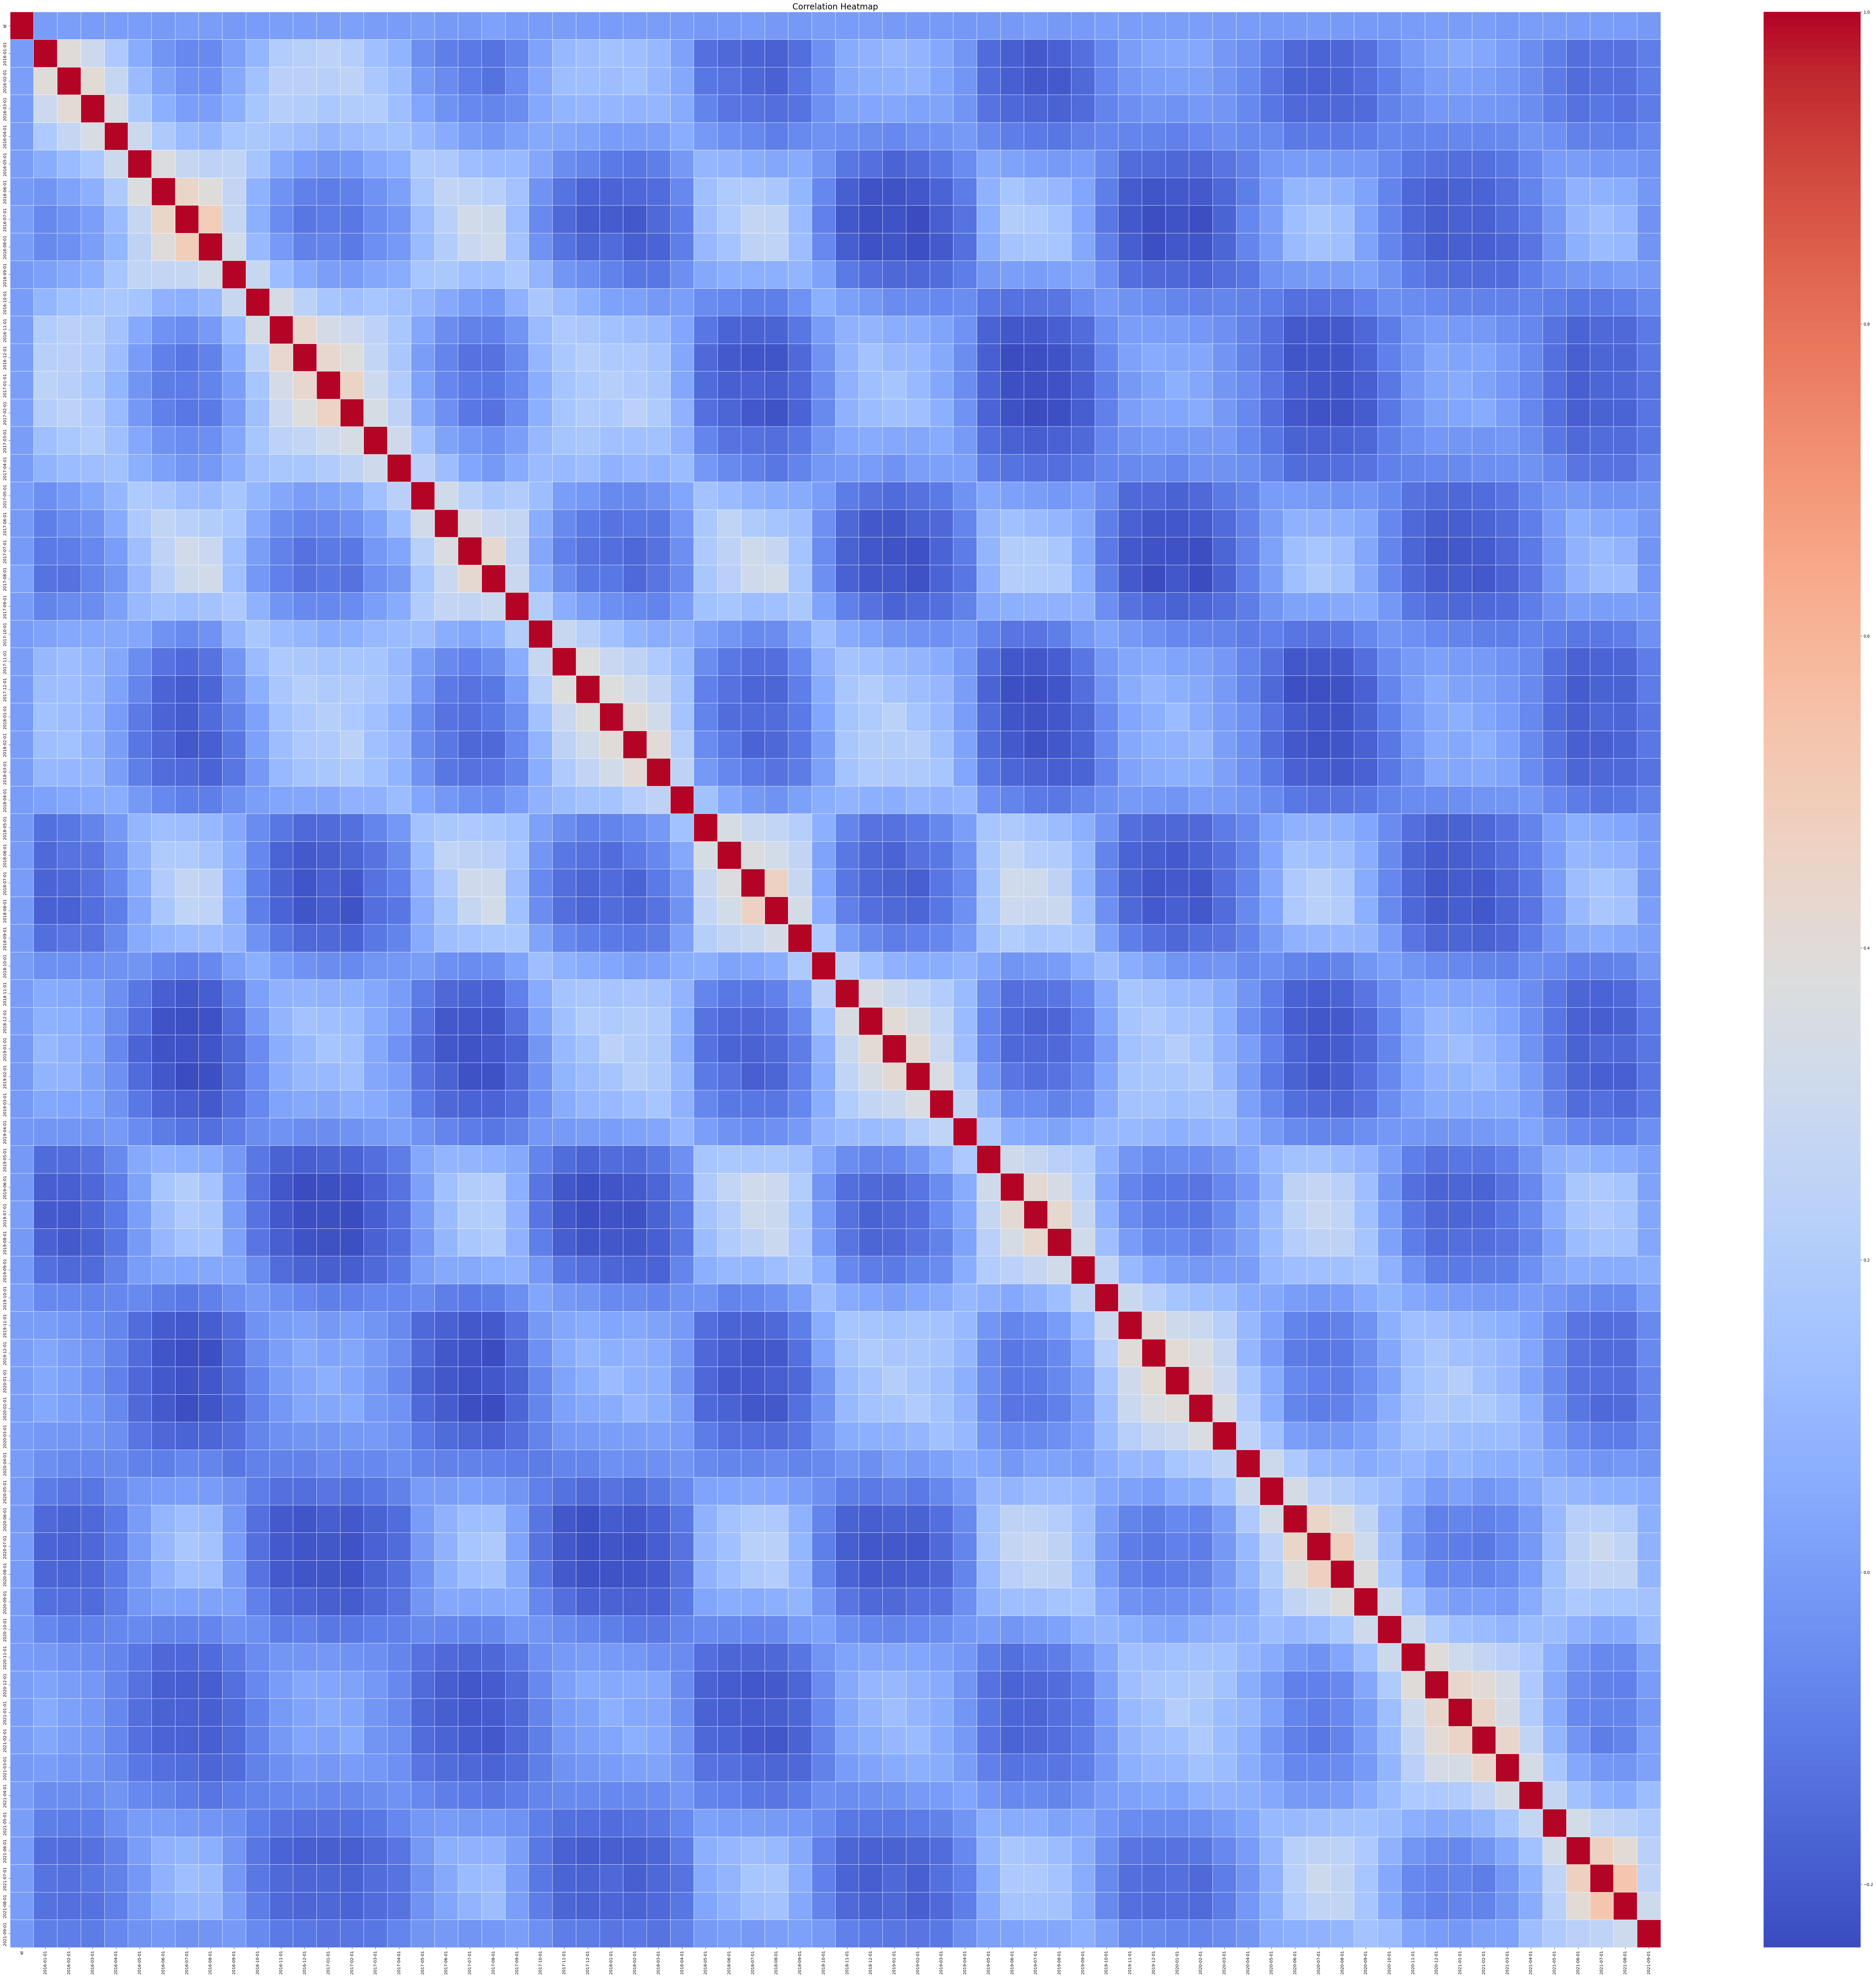

In [275]:
plt.figure(figsize=(90, 85))
sns.heatmap(mtx, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

Ввиду большого количества столбцов трудно проанализировать такую карту. Но заметим, что присутствуют цвета, которые близко находятся к значению 0,4 - 0,5. Выберем эти столбцы для анализа.

In [282]:
f_matr = mtx.where(np.triu(np.ones(mtx.shape), k=1).astype(bool))
rows, cols = np.where(f_matr > 0.4)
columns_above_threshold = set(f_matr.index[rows]).union(set(f_matr.columns[cols]))
columns_to_keep = ['id'] + [col for col in dp_f.columns if col in columns_above_threshold]
df_filt = dp_f[columns_to_keep]

In [283]:
df_filt.head()

id  2016-02-01  2016-03-01  2016-06-01  2016-07-01  2016-08-01  \
0   6125      -0.040       0.190      -0.950      -2.910      -1.540   
1  26781       0.390      -0.470      -0.510       0.510       0.040   
2  13333       0.354       0.237      -0.290      -1.260       0.170   
3  53218       1.550      -0.030       0.600       0.270       1.290   
4  84204       1.390      -1.030       1.770       1.430       1.460   

   2016-11-01  2016-12-01  2017-01-01  2017-02-01  ...  2020-06-01  \
0       1.050       0.800       2.240       0.070  ...      -2.480   
1       0.110       1.960       0.560       1.030  ...      -1.150   
2      -0.940       0.160      -0.050      -0.900  ...      -0.502   
3       0.260      -0.220      -0.380      -2.220  ...      -0.930   
4       0.860       1.970       1.060      -0.560  ...       0.890   

   2020-07-01  2020-08-01  2020-12-01  2021-01-01  2021-02-01  2021-03-01  \
0      -1.030      -1.470       0.213       0.195       0.133       0.035   
1       2.380      -0.381       0.213       0.195       0.133       0.035   
2      -1.222      -0.082       1.388       0.195       0.133       0.035   
3       0.290       0.660       0.920      -1.080       0.140      -0.470   
4      -0.240      -0.180      -1.737      -0.287      -1.827      -1.257   

   2021-06-01  2021-07-01  2021-08-01  
0      -0.344      -0.309      -0.274  
1      -0.344      -0.309      -0.274  
2      -0.344      -0.309      -0.274  
3       0.140       1.720      -0.720  
4      -0.344      -0.309      -0.274  

[5 rows x 35 columns]

Также проанализировав полученные выборки получаем, что в тестовой сборке отсутствует столбец '2018-01-01'. Поэтому для того, чтобы модель смогла предсказать данные на тестовой выборке добавим этот столбец в вывборку.

In [285]:
columns_to_keep = ['id'] + [col for col in dp_f.columns if col in columns_above_threshold or col == '2018-01-01']
df_filt = df_filt[columns_to_keep]

In [286]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          20000 non-null  int64  
 1   2016-02-01  20000 non-null  float64
 2   2016-03-01  20000 non-null  float64
 3   2016-06-01  20000 non-null  float64
 4   2016-07-01  20000 non-null  float64
 5   2016-08-01  20000 non-null  float64
 6   2016-11-01  20000 non-null  float64
 7   2016-12-01  20000 non-null  float64
 8   2017-01-01  20000 non-null  float64
 9   2017-02-01  20000 non-null  float64
 10  2017-07-01  20000 non-null  float64
 11  2017-08-01  20000 non-null  float64
 12  2018-01-01  20000 non-null  float64
 13  2018-02-01  20000 non-null  float64
 14  2018-03-01  20000 non-null  float64
 15  2018-07-01  20000 non-null  float64
 16  2018-08-01  20000 non-null  float64
 17  2018-12-01  20000 non-null  float64
 18  2019-01-01  20000 non-null  float64
 19  2019-02-01  20000 non-nul

In [287]:
df_filt.head()

id  2016-02-01  2016-03-01  2016-06-01  2016-07-01  2016-08-01  \
0   6125      -0.040       0.190      -0.950      -2.910      -1.540   
1  26781       0.390      -0.470      -0.510       0.510       0.040   
2  13333       0.354       0.237      -0.290      -1.260       0.170   
3  53218       1.550      -0.030       0.600       0.270       1.290   
4  84204       1.390      -1.030       1.770       1.430       1.460   

   2016-11-01  2016-12-01  2017-01-01  2017-02-01  ...  2020-06-01  \
0       1.050       0.800       2.240       0.070  ...      -2.480   
1       0.110       1.960       0.560       1.030  ...      -1.150   
2      -0.940       0.160      -0.050      -0.900  ...      -0.502   
3       0.260      -0.220      -0.380      -2.220  ...      -0.930   
4       0.860       1.970       1.060      -0.560  ...       0.890   

   2020-07-01  2020-08-01  2020-12-01  2021-01-01  2021-02-01  2021-03-01  \
0      -1.030      -1.470       0.213       0.195       0.133       0.035   
1       2.380      -0.381       0.213       0.195       0.133       0.035   
2      -1.222      -0.082       1.388       0.195       0.133       0.035   
3       0.290       0.660       0.920      -1.080       0.140      -0.470   
4      -0.240      -0.180      -1.737      -0.287      -1.827      -1.257   

   2021-06-01  2021-07-01  2021-08-01  
0      -0.344      -0.309      -0.274  
1      -0.344      -0.309      -0.274  
2      -0.344      -0.309      -0.274  
3       0.140       1.720      -0.720  
4      -0.344      -0.309      -0.274  

[5 rows x 35 columns]

Получаем, что у нас итоговая выборка содержит 35 столбцjd. Построим тепловую карту для этой выборки.

<Figure size 3000x2500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

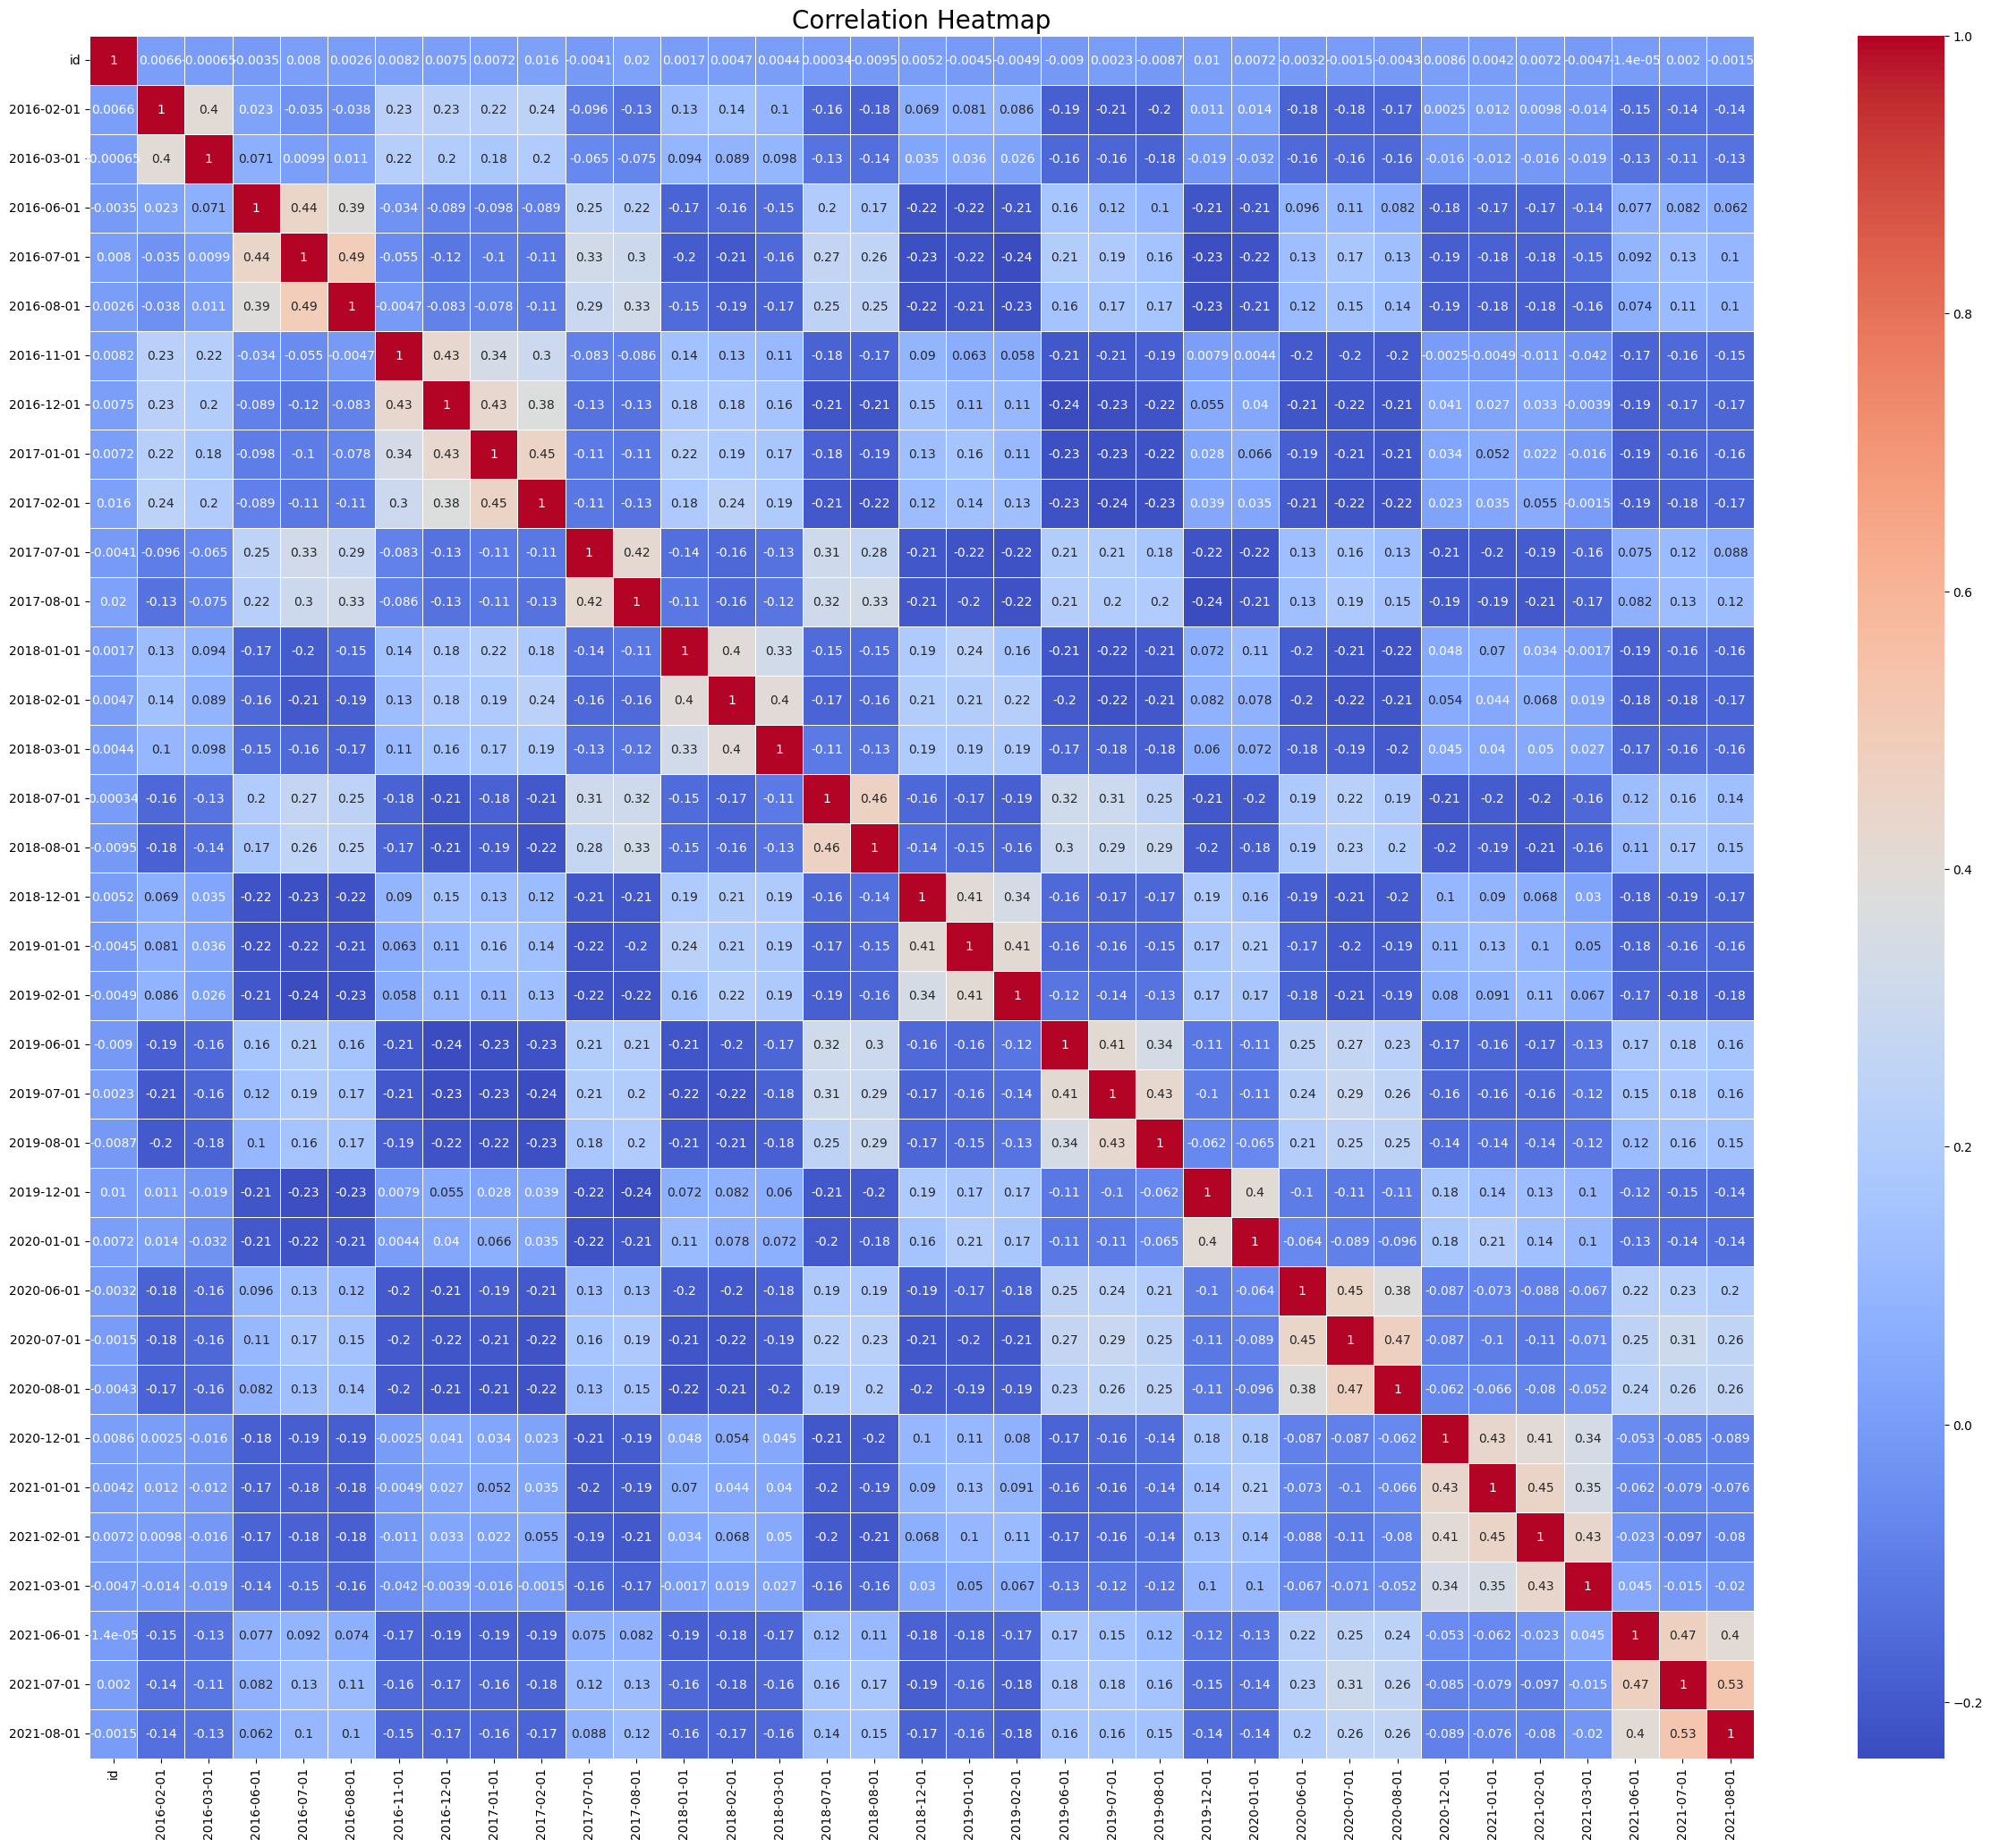

In [288]:
plt.figure(figsize=(30, 25))
sns.heatmap(df_filt.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

По графику видно, что столбец '2018-01-01' имеет коэффициент 0.4, что значит, что он подходит для выборки. Также заметим, что присутствует сильная корреляция между начальными месяцами каждого года и между месяцами в третьей четверти (7, 8, 9 месяца).

По итогам экспериметов на тренировочной выборке наилучшей моделью была CatBoost (c_model_t). Вычислим предсказания с помощью этой модели.

In [289]:
final_model = joblib.load('c_model_t') 

In [290]:
final_model.get_params()

{'iterations': 305,
 'learning_rate': 0.1,
 'depth': 5,
 'l2_leaf_reg': 30,
 'custom_metric': 'AUC'}

In [141]:
y_fin_pred = final_model.predict_proba(df_filt)[:, 1]

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 12 should be feature with name 2018-01-01 (found 2018-02-01).